## Initialization

In [ ]:
import os
import grasp
import numpy as np
import pandas as pd
from astropy import units as u
import matplotlib.pyplot as plt
dr3 = grasp.dr3()
gc = grasp.Cluster('ngc6121')

try:
    device_name = os.getenv('COMPUTERNAME')
    if device_name == 'DESKTOP-Work':
        tn1 = '20250506_170539'
        tn2 = '20250506_170541'
        tn3 = '20250515_193141'
        acs = grasp.load_data(tn = tn1)
        pcs = grasp.load_data(tn = tn2)
        fas = grasp.load_data(tn = tn3)
    elif device_name == 'LAPTOP-Work':
        tn1 = '20250401_164228'
        tn2 = '20250401_164231'
        tn3 = '20250515_094935'
        pcs = grasp.load_data(tn = tn1, data_format='ascii.tab', file_format='.txt')
        acs = grasp.load_data(tn = tn2, data_format='ascii.tab', file_format='.txt')
        fas = grasp.load_data(tn = tn3)
    else:
        raise EnvironmentError("Unknown device name")
    acs.gc = pcs.gc = fas.gc = gc
except FileNotFoundError as e:
    print(e)
    astrometry_query = "SELECT source_id, ra, ra_error, dec, dec_error, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error, \
                        radial_velocity, radial_velocity_error, bp_rp, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, teff_gspphot, ra_dec_corr, pmra_pmdec_corr \
                        FROM gaiadr3.gaia_source \
                        WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',245.897,-26.526,0.86))=1 \
                        AND parallax IS NOT NULL AND parallax>0.531632110579479 AND parallax<0.5491488193300\
                        AND abs(parallax_error/parallax)<0.50\
                        AND abs(pmra_error/pmra)<0.30 \
                        AND abs(pmdec_error/pmdec)<0.30 \
                        AND pmra IS NOT NULL AND abs(pmra)>0 \
                        AND pmdec IS NOT NULL AND abs(pmdec)>0 \
                        AND pmra BETWEEN -13.742720 AND -11.295338 \
                        AND pmdec BETWEEN -20.214805 AND -17.807517"
    
    photometry_query = "SELECT source_id, ra, ra_error, dec_error, dec, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error, radial_velocity, radial_velocity_error, \
                        bp_rp, phot_g_mean_mag, phot_bp_rp_excess_factor, teff_gspphot, ra_dec_corr, pmra_pmdec_corr \
                        FROM gaiadr3.gaia_source \
                        WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',245.8958,-26.5256,0.86))=1 \
                        AND parallax IS NOT NULL AND parallax>0.531632110579479 AND parallax<0.5491488193300\
                        AND ruwe < 1.15 \
                        AND phot_g_mean_mag > 11 \
                        AND astrometric_excess_noise_sig < 2 \
                        AND pmra BETWEEN -13.742720 AND -11.295338 \
                        AND pmdec BETWEEN -20.2148 AND -17.807517"
    acs = dr3.free_query(astrometry_query, save=True)
    acs = grasp.Sample(acs, gc)
    pcs = dr3.free_query(photometry_query, save=True)
    pcs = grasp.Sample(pcs, gc)
    fas = dr3.get_astrometry(1., 'ngc6121', save=True)
    print("\nWARNING! Remember to updates tn after running the new query!!!")



            ..............
         ..:;;..:;;;;;:::::;;
       ;;;;;;::.::;;;;;;;;;;;;;
      ;;;;.:;;;..;XXXXXX.::....:           GAIA QUERY MODULE
     :;::;::..+XXXXXXXXX+:;;;;;;:
    ;::;:.:;;:XXXXXXXXXXX::::::::;        __ _  __ _(_) __ _
    .;;..;;;:.:XXXXXXXXX$$$$$$$$$$X.     / _` |/ _` | |/ _` |
    :;..:;;;..:xXXXXXXX$$$$$$$$$$$$X    | (_| | (_| | | (_| |
    :;:.:;;.XXXXXXXXX$$$$$$$$$$$$$$;     \__, |\__,_|_|\__,_|
    .;;:.:X$$$$$$$$$$$$$$$$$$$$$$X.      |___/
    ..:;:$$$$$$$$$$$$$$$$$$$$$$X;.
     :;;;$$$$$$$$$$$$$$$$$$$$::;;             INITIALIZED
      ...;$$$$$$$$$$$$$$x;:;;;;;
        ......:;:....;;;;;;;:.
          ::::::::::;;;::...
            ....::::.....

Initialized with Gaia table: 'gaiadr3.gaia_source'
Not a Cluster: no model available
Not a Cluster: no model available


In [2]:
aps = acs.join(pcs)
aps.gc.dist = 1851 * u.pc # Baumgardt, Vasiliev: 2021 # pc
f = grasp.load_base_formulary()
aps.info()

<Sample length=1014>
          name            dtype     class     n_bad
------------------------ ------- ------------ -----
               SOURCE_ID   int64       Column     0
                      ra float64       Column     0
                ra_error float32       Column     0
                     dec float64       Column     0
               dec_error float32       Column     0
                parallax float64       Column     0
          parallax_error float32       Column     0
                    pmra float64       Column     0
              pmra_error float32       Column     0
                   pmdec float64       Column     0
             pmdec_error float32       Column     0
         radial_velocity float32 MaskedColumn   923
   radial_velocity_error float32 MaskedColumn   923
                   bp_rp float32 MaskedColumn    31
         phot_g_mean_mag float32 MaskedColumn     1
        phot_bp_mean_mag float32 MaskedColumn   118
        phot_rp_mean_mag float32 MaskedColu

# MachineLearning

## Golden-Sample XDGMM

### PMRA ($\mu_\alpha$) 
KDE mean

In [ ]:
pmra = aps.pmra
pmra_kde = grasp.plots.histogram(pmra, xlabel='pmra', kde=True, kde_kind='gaussian', out=True)['kde']
pmra_mean = pmra_kde[1]
print(f"{pmra_mean = :.4f}")

### PMDEC ($\mu_{\delta^*}$) 
KDE mean

In [ ]:
pmdec = aps.pmdec
pmdec_kde = grasp.plots.histogram(pmdec, xlabel='pmra', kde=True, kde_kind='gaussian', out=True)['kde']
pmdec_mean = pmdec_kde[1]
print(f"{pmdec_mean = :.4f}")

### XDGMM (eXtreme Deconvolution Gaussian Mixture Model)

For cluster parameters estimation from subsample, to be checked with PM regression and with clustering classification

In [ ]:
ra, dec = ((aps.ra * u.deg).to(u.rad).value, (aps.dec * u.deg).to(u.rad).value)
f.substitute(
    "Angular separation",
    {"alpha_{0}": aps.gc.ra.to(u.rad).value, "delta_{0}": aps.gc.dec.to(u.rad).value},
)
theta_GC = f.compute(
    "Angular Separation",
    data={"alpha_{1}": ra, "delta_{1}": dec},
    errors={"epsilon_alpha_{1}": aps.ra_error, "epsilon_delta_{1}": aps.dec_error},
    asarray=True,
)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as ac, mean_absolute_error as mea, mean_squared_error as mse

data = np.array([aps.SOURCE_ID, aps.pmra, aps.pmdec, theta_GC[0]]).T
errors = np.array([aps.SOURCE_ID, aps.pmra_error, aps.pmdec_error, theta_GC[1]]).T
correlation = aps.pmra_pmdec_corr.value

In [ ]:
X_train, X_test, err_train, err_test, corr_train, corr_test = train_test_split(data, errors, correlation, test_size=0.2)
if all(X_train[:,0] == err_train[:,0]) and all(X_test[:,0] == err_test[:,0]):
    print("Data and errors are aligned.\nRemoving source_id column...\n")
    err_train = np.delete(err_train, 0, axis=1)
    err_test = np.delete(err_test, 0, axis=1)
    X_train = np.delete(X_train, 0, axis=1)
    X_test = np.delete(X_test, 0, axis=1)
else:
    print("Data and errors are not aligned. Exiting...")
    exit(1)
print(f"{X_train.shape = :}")
print(f"{X_test.shape = :}\n")
print(f"{err_train.shape = :}")
print(f"{err_test.shape = :}")
print(f"\n{corr_train.shape = :}")
print(f"{corr_test.shape = :}\n")

In [ ]:
train_cov = grasp.stats._construct_covariance_matrices(err_train, {(0,1): corr_train})
test_cov = grasp.stats._construct_covariance_matrices(err_test, {(0,1): corr_test})
print(f"{train_cov.shape = :}")
print(f"{test_cov.shape = :}\n")

In [ ]:
model = grasp.stats.XD_estimator(data=X_train, errors=err_train, correlations={(0,1): corr_train}, n_components=1)

In [ ]:
xdgmm_pmra_mean, xdgmm_pmdec_mean, _ = tuple([mu[0] for mu in model.mu.T])
print(f"{pmra_mean = :.3f} mas/yr  ;  {pmdec_mean = :.3f} mas/yr\n")
print(f"{xdgmm_pmra_mean = :.3f} mas/yr  ;  {xdgmm_pmdec_mean = :.3f} mas/yr")

In [ ]:
print(f"{xdgmm_pmra_mean/pmra_mean*100 = :.3f} %")
print(f"{xdgmm_pmdec_mean/pmdec_mean*100 = :.3f} %")

## GMM on Full Sample

### Feature Engeneering

In [ ]:
fas = dr3.free_gc_query(
    1.2,
    'ngc6121', 
    data = 'source_id, ra, ra_error, dec, dec_error, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error,ra_dec_corr,pmra_pmdec_corr',
    save=True
)
Ni = len(fas)
fas.join(aps, keep='left_only', inplace=True)
Nf = len(fas)
assert Ni-Nf == len(aps), f"Number of sources in fas ({Ni-Nf}) is not equal to the number of sources in aps ({len(aps)})"

fas.drop_columns(
    [
        "radial_velocity",
        "radial_velocity_error",
        "bp_rp",
        "phot_g_mean_mag",
        "teff_gspphot",
        "phot_bp_mean_mag",
        "phot_rp_mean_mag",
        "phot_bp_rp_excess_factor"
    ]
)

fas.dropna()

In [ ]:
pmra_dist = grasp.plots.histogram(fas['pmra'].value, bins='knuth', kde=True ,xlabel='pmra', out=True)
pmdec_dits = grasp.plots.histogram(fas['pmdec'].value, bins='knuth', kde=True ,xlabel='pmdec', out=True)

Removing extreme outliers

In [ ]:
fas.apply_conditions(
    conditions={
        "pmra": f"<50",
        "pmra": f">-50",
        "pmdec":f"<50",
        "pmdec":f">-50",
    },
    inplace=True,
)

In [ ]:
grasp.plots.doubleHistScatter(fas.pmra, fas.pmdec, size=0.05, alpha=0.85)

In [ ]:
#f.var_order('angular separation')
fas['ang_sep'], fas['ang_sep_error'] = f.compute('angular separation',
          data={'alpha_{1}': (fas.ra*u.deg).to(u.rad).value, 'delta_{1}': (fas.dec*u.deg).to(u.rad).value}, 
          errors={"epsilon_alpha_{1}": (fas.ra_error*u.deg).to(u.rad).value, "epsilon_delta_{1}": (fas.dec_error*u.deg).to(u.rad).value}, 
          corrs={'rho_alpha_{1}_delta_{1}': fas.ra_dec_corr},
          asarray=True)

fas['ang_sep_over_error'] = fas['ang_sep_error'] / fas['ang_sep']
fas.apply_conditions('ang_sep_over_error < 3.0', inplace=True)

fas[['ang_sep', 'ang_sep_error', 'ang_sep_over_error']].describe()

In [ ]:
grasp.plots.histogram(fas['ang_sep_over_error'], bins='knuth', xlabel='AngSep OverError', out=False)

In [ ]:
data = fas[['ra','dec','pmra','pmdec', 'parallax']].to_numpy()
X_train, X_test = train_test_split(data, test_size=0.33)

pfas = fas.apply_conditions('parallax>0', inplace=False)
print(f"Parallax cleaned sample is {len(pfas)/len(fas)*100:.2f} % of the original sample")

data2 = pfas[['ra','dec','pmra','pmdec', 'parallax']].to_numpy()
X_train2, X_test2 = train_test_split(data2, test_size=0.33)

### Single GMM

#### Model1: GMM with  $\,\forall \bar{\omega} \in \mathcal{R}$

```python
model1 = grasp.stats.gaussian_mixture_model(train_data=X_train, G=3, modelNames=np.array(['VII', 'VVI']), verbose=True)
plt.scatter(X_train[:,2], X_train[:,3], c=model1.train_classification['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(model1.train_classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(model1.train_classification['classification'])])
plt.title('Model1: G=3 with full parallaxes')
pd.DataFrame(data=model1.train_classification['classification']).value_counts()
model1_parameters = pd.DataFrame(data=model1.coeffs, index=['G1','G2','G3'], columns=['ra','dec','pmra','pmdec','parallax'])
print(model1_parameters)
predictions = model1.predict(X_test)
plt.scatter(X_test[:,2], X_test[:,3], c=predictions['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(predictions['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(predictions['classification'])])
plt.title('Model1 Test Set')
```

#### Model2: GMM with $\,\forall\bar{\omega}\in\mathcal{R}^+$

```python
model2 = grasp.stats.gaussian_mixture_model(train_data=X_train2, G=3, modelNames=np.array(['VII', 'VVI']), verbose=True)
plt.scatter(X_train2[:,2], X_train2[:,3], c=model2.train_classification['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(model2.train_classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(model2.train_classification['classification'])])
plt.title('Model2: G=3 with parallax cut')

pd.DataFrame(data=model2.train_classification['classification']).value_counts()
model2_parameters = pd.DataFrame(data=model2.coeffs, index=['G1','G2','G3'], columns=['ra','dec','pmra','pmdec','parallax'])
print(model2_parameters)
predictions2 = model2.predict(X_test2)
plt.scatter(X_test2[:,2], X_test2[:,3], c=predictions2['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(predictions2['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(predictions2['classification'])])
plt.title('Model2 Test Set')
```

#### Model3: $G=2$ with $\forall\bar{\omega}\in\mathcal{R}^+$

```python
model3 = grasp.stats.gaussian_mixture_model(train_data=X_train2, G=2, modelNames=np.array(['VII', 'VVI']), verbose=True)
plt.scatter(X_train2[:,2], X_train2[:,3], c=model3.train_classification['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(model3.train_classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(model3.train_classification['classification'])])
plt.title('Model3: G=2 with parallax cut')

pd.DataFrame(data=model3.train_classification['classification']).value_counts()
predictions3 = model3.predict(X_test2)
model3_parameters = pd.DataFrame(data=model3.coeffs, index=['G1','G2'], columns=['ra','dec','pmra','pmdec','parallax'])
print(model3_parameters)
plt.scatter(X_test2[:,2], X_test2[:,3], c=predictions3['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(predictions3['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(predictions3['classification'])])
plt.title('Model3 Test Set')

#### Model4: $G=2$ with $\forall\bar{\omega}\in\mathcal{R}$

```python
model4 = grasp.stats.gaussian_mixture_model(train_data=X_train, G=2, modelNames=np.array(['VII', 'VVI']), verbose=True)
plt.scatter(X_train2[:,2], X_train2[:,3], c=model4.train_classification['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(model4.train_classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(model4.train_classification['classification'])])
plt.title('Model3: G=2 with parallax cut')

pd.DataFrame(data=model4.train_classification['classification']).value_counts()
predictions4 = model4.predict(X_test2)
model4_parameters = pd.DataFrame(data=model4.coeffs, index=['G1','G2'], columns=['ra','dec','pmra','pmdec','parallax'])
print(model4_parameters)
plt.scatter(X_test2[:,2], X_test2[:,3], c=predictions4['classification'], cmap='plasma', s=0.5, alpha=0.5)
cbar = plt.colorbar(ticks=np.unique(predictions4['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(predictions4['classification'])])
plt.title('Model3 Test Set')

### KFold Cross-Validation with GMM

#### G=3  -  $\forall\bar{\omega}\in\mathcal{R}^+$ 

In [ ]:
nfolds = 20
kfold_model = grasp.stats.kfold_gmm_estimator(
    data=data2,
    folds=nfolds,
    G=3,
    modelNames=np.array(['VII', 'VVI']),
    verbose=False
)

In [ ]:
plt.plot(np.arange(1,nfolds+1), kfold_model.bics, '-o', label='Models BIC')
plt.plot([1,nfolds+1], [kfold_model.mean_bic,kfold_model.mean_bic], '--', label='Mean BIC')
plt.xticks(ticks=np.arange(1, nfolds + 2, 1))
plt.grid(True)
plt.title('BIC vs Number of folds')
plt.xlabel('Fold number')
plt.ylabel('BIC')
plt.legend(loc='best')

print(f"Model's BIC Variance: {(np.min(kfold_model.bics) - np.max(kfold_model.bics))/np.max(kfold_model.bics) * 100:.3f} %")

#### G=2  -  $\forall\bar{\omega}\in\mathcal{R}^+$ 

In [ ]:
nfolds = 20
kfold_model2 = grasp.stats.kfold_gmm_estimator(
    data=data2,
    folds=nfolds,
    G=2,
    modelNames=np.array(['VII', 'VVI']),
    verbose=False
)

In [ ]:
plt.plot(np.arange(1,nfolds+1), kfold_model2.bics, '-o', label='Models BIC')
plt.plot([1,nfolds+1], [kfold_model2.mean_bic,kfold_model2.mean_bic], '--', label='Mean BIC')
plt.xticks(ticks=np.arange(1, nfolds + 2, 1))
plt.grid(True)
plt.title('BIC vs Number of folds')
plt.xlabel('Fold number')
plt.ylabel('BIC')
plt.legend(loc='best')

print(f"Model's BIC Variance: {(np.min(kfold_model2.bics) - np.max(kfold_model2.bics))/np.max(kfold_model2.bics) * 100:.3f} %")

#### G=3  -  $\forall\bar{\omega}\in\mathcal{R}$

#### G=2  -  $\forall\bar{\omega}\in\mathcal{R}$

#### Best Model Selection

In [ ]:
plt.plot(np.arange(1,nfolds+1), kfold_model.bics, '-o', label='Models1 BIC')
plt.plot([1,nfolds+1], [kfold_model.mean_bic,kfold_model.mean_bic], '--', label='Mean BIC')
plt.plot(np.arange(1,nfolds+1), kfold_model2.bics, '-o', label='Models2 BIC')
plt.plot([1,nfolds+1], [kfold_model2.mean_bic,kfold_model2.mean_bic], '--', label='Mean BIC')
plt.xticks(ticks=np.arange(1, nfolds + 2, 1))
plt.grid(True)
plt.title('BIC vs Number of folds')
plt.xlabel('Fold number')
plt.ylabel('BIC')
plt.legend(loc='best')

In [ ]:
best_model = kfold_model.best_model()
best_model2 = kfold_model2.best_model()

In [ ]:
print(f"Best 3-G Model:\n {pd.DataFrame(best_model.coeffs, columns=['ra','dec','pmra','pmdec','parallax'])}\n")
print(f"Best 2-G Model:\n{pd.DataFrame(best_model2.coeffs, columns=['ra','dec','pmra','pmdec','parallax'])}")

In [ ]:
bm2_data = best_model2.data

text = pd.DataFrame(data=best_model2.train_classification['classification'], columns=['Cluster']).value_counts()
plt.scatter(bm2_data[:,2], bm2_data[:,3], c=best_model2.train_classification['classification'], cmap='viridis_r', s=0.5, alpha=0.5, label=text)
cbar = plt.colorbar(ticks=np.unique(best_model2.train_classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(best_model2.train_classification['classification'])])
plt.legend(loc='best')
plt.xlabel('pmra (mas/yr)')
plt.ylabel('pmdec (mas/yr)')
plt.title('Best Model: G=2 with parallax cut')

In [ ]:
bm3_data = best_model.data

text = pd.DataFrame(data=best_model.train_classification['classification'], columns=['Cluster']).value_counts()
plt.scatter(bm3_data[:,2], bm3_data[:,3], c=best_model.train_classification['classification'], cmap='viridis_r', s=0.5, alpha=0.5, label=text)
cbar = plt.colorbar(ticks=np.unique(best_model.train_classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(best_model.train_classification['classification'])])
plt.legend(loc='best')
plt.xlabel('pmra (mas/yr)')
plt.ylabel('pmdec (mas/yr)')
plt.title('Best Model: G=3 with parallax cut')

In [ ]:
best_model.save_model(grasp.gpaths.CLUSTER_DATA_FOLDER('ngc6121')+'/BEST_3C_MODEL')
best_model2.save_model(grasp.gpaths.CLUSTER_DATA_FOLDER('ngc6121')+'/BEST_2C_MODEL')

### Try the predict on the Golden Sample

In [ ]:
aps.drop_columns(
    [
        "radial_velocity",
        "radial_velocity_error",
        "bp_rp",
        "phot_g_mean_mag",
        "teff_gspphot",
        "phot_bp_mean_mag",
        "phot_rp_mean_mag",
        "phot_bp_rp_excess_factor"
    ]
)
aps.info()

In [ ]:
gs_data = aps.to_numpy(columns=['ra','dec','pmra','pmdec', 'parallax'])

_ = best_model2.predict(gs_data)
_ = best_model.predict(gs_data)

In [ ]:
text = pd.DataFrame(data=best_model.classification['classification'], columns=['Cluster']).value_counts()
plt.scatter(gs_data[:,2], gs_data[:,3], marker='+', c=best_model.classification['classification'], cmap='rainbow_r', s=10, label=text)
cbar = plt.colorbar(ticks=np.unique(best_model.classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(best_model.classification['classification'])])
plt.legend(loc='best')
plt.title('Best Model: G=3 with parallax cut')

In [ ]:
text = pd.DataFrame(data=best_model2.classification['classification'], columns=['Cluster']).value_counts()
plt.scatter(gs_data[:,2], gs_data[:,3], marker='+', c=best_model2.classification['classification'], cmap='rainbow_r', s=10, label=text)
cbar = plt.colorbar(ticks=np.unique(best_model2.classification['classification']))
cbar.ax.set_yticklabels([f"C_{val}" for val in np.unique(best_model2.classification['classification'])])
plt.legend(loc='best')
plt.title('Best Model: G=2 with parallax cut')

In [ ]:
print("Proper Motions RA")
print(f"{'kde':<10} {'xdgmm':<10} {'gmm2':<10} {'gmm3':<10}")
print(f"{pmra_mean:<10.3f} {xdgmm_pmra_mean:<10.3f} {best_model2.coeffs[1,2]:<10.3f} {best_model.coeffs[2,2]:<10.3f}\n")

print("Proper Motions DEC")
print(f"{'kde':<10} {'xdgmm':<10} {'gmm2':<10} {'gmm3':<10}")
print(f"{pmdec_mean:<10.3f} {xdgmm_pmdec_mean:<10.3f} {best_model2.coeffs[1,3]:<10.3f} {best_model.coeffs[2,3]:<10.3f}")

In [ ]:
pmrameans = np.array([pmra_mean, xdgmm_pmra_mean, best_model2.coeffs[1,2], best_model.coeffs[2,2]])
pmdecmeans = np.array([pmdec_mean, xdgmm_pmdec_mean, best_model2.coeffs[1,3], best_model.coeffs[2,3]])

print(f"pmra = {np.mean(pmrameans):.3f} $\\pm$ {np.std(pmrameans)/np.sqrt(len(pmrameans)):.3f}")
print(f"pmdec = {np.mean(pmdecmeans):.3f} $\\pm$ {np.std(pmdecmeans)/np.sqrt(len(pmdecmeans)):.3f}")

In [ ]:
print("Parallax")
print(f"{'gmm2':<10} {'gmm3':<10}")
print(f"{best_model2.coeffs[1,4]:<10.3f} {best_model.coeffs[2,4]:<10.3f}\n")

In [ ]:
parallaxmeans = np.array([best_model2.coeffs[1,4], best_model.coeffs[2,4]])
print(f"parallax = {np.mean(parallaxmeans):.3f} $\\pm$ {np.std(parallaxmeans)/np.sqrt(len(parallaxmeans)):.3f}")

# Effective Potential Computation

### Loading the model and computing all the quantities

In [ ]:
best_model = grasp.GaussianMixtureModel.load_model(
    grasp.gpaths.CLUSTER_DATA_FOLDER('ngc6121')+'/BEST_2C_MODEL'
)

Utilizzando quaattro metodi diversi, si è calcolato il valore medio dei parametri per il cluster:

La media è stata calcolata con la formula classica, mentre l'uncertainty è stata stimata come 

$$\epsilon = \dfrac{\sigma}{\sqrt{N}}$$

> $ \big<\bar{\omega}\big> = 0.550 \pm 0.002 \, \mathrm{mas} $ (~ 1.81 Kpc)

> $ \big<\mu_\alpha\big> = -12.528 \pm 0.003 \, \mathrm{mas\cdot yr}^{-1}$

> $ \big<\mu_{\delta^*}\big> = -19.022 \pm 0.005 \, \mathrm{mas\cdot yr}^{-1}$


In [ ]:
gs_data = aps.to_numpy(columns=['ra','dec','pmra','pmdec', 'parallax'])
_ = best_model.predict(gs_data)
bm2_data = best_model2.data

gc.ra, gc.dec = (best_model.coeffs[1,0], best_model2.coeffs[1,1])
print(gc.ra, gc.dec)

Correctly imported `mclust`.
245.89812095159058 -26.5275536664354


In [ ]:
# mu_ra = np.array([np.mean(pmrameans), np.std(pmrameans)/np.sqrt(len(pmrameans))])
# mu_dec = np.array([np.mean(pmdecmeans), np.std(pmdecmeans)/np.sqrt(len(pmdecmeans))])
# px = np.array([np.mean(parallaxmeans), np.std(parallaxmeans)/np.sqrt(len(parallaxmeans))])

# Se si riparte direttamente da qui...
mu_ra = (-12.528 ,0.003)
mu_dec = (-19.022 ,0.005)
px = (0.550 ,0.002)

gc.px = (px[0] * u.mas, px[1] * u.mas)
gc.pmra = (mu_ra[0] * u.mas / u.yr, mu_ra[1] * u.mas / u.yr)
gc.pmdec = (mu_dec[0] * u.mas / u.yr, mu_dec[1] * u.mas / u.yr)

print(f"{bm2_data.shape = } {gs_data.shape = }\n")
gc_data = bm2_data[np.array(best_model.train_classification['classification']) == 2.]
gc2_data = gs_data[np.array(best_model.classification['classification']) == 2.]
print(f"{gc_data.shape = } {gc2_data.shape = }")

predicted_sample = np.vstack((gc_data, gc2_data))

assert len(predicted_sample) == len(gc_data) + len(gc2_data), f"Predicted sample length {len(predicted_sample)} is not equal to the sum of gc_data {len(gc_data)} and gs_data {len(gc2_data)}"

print(f"\n{predicted_sample.shape = }")

bm2_data.shape = (171155, 5) gs_data.shape = (1014, 5)

gc_data.shape = (15817, 5) gc2_data.shape = (1009, 5)

predicted_sample.shape = (16826, 5)


In [6]:
gc_data = pd.DataFrame(data=predicted_sample, columns=['ra','dec','pmra','pmdec', 'parallax'])
gc_sample = grasp.Sample(gc_data, gc)
gc_sample.update_gc_params(ra=gc_sample.ra.mean(), dec=gc_sample.dec.mean())


Harris Catalog 2010 edition Parameters

       Key                  Value
----------------------------------------
.id      Cluster Name       NGC6121
.ra      Position in sky    RA  245.90
.dec                        DEC -26.53
.dist    Distance           1851.00 pc
.w0      W0 Parameter       7.41
.logc    Concentration      logc=1.65
.cflag                      Collapsed -> False
.rc      Core radius        0.019 deg
.rh      Half-Light radius  0.072 deg
.rt      Tidal Radius       0.864 deg



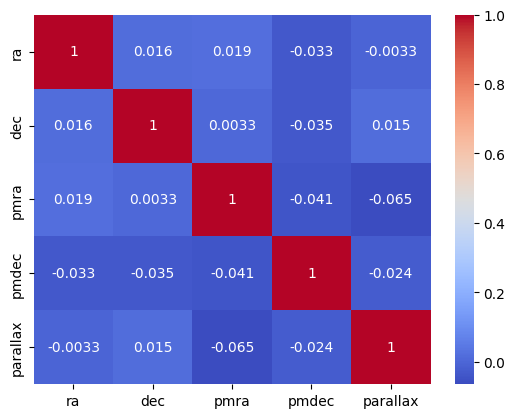

In [7]:
grasp.plots.seaborn(which='heatmap', data=gc_sample.to_pandas().corr(), annot=True, cmap='coolwarm', cbar=True)

In [8]:
ff = grasp.load_base_formulary()
ff.substitute(
    "Angular separation",
    {"alpha_{0}": (gc_sample.gc.ra*u.deg).to(u.rad).value, "delta_{0}": (gc_sample.gc.dec*u.deg).to(u.rad).value}
)
ff.angular_separation

Eq(theta, 2*asin(sqrt(0.894722019329703*sin(alpha_{1}/2 - 2.14586776004826)**2*cos(delta_{1}) + sin(delta_{1}/2 + 0.231493958786548)**2)))

In [9]:
gc_sample.reset_sample()

In [10]:
gc_sample.apply_conditions('parallax>0.05', inplace=True)
N=len(gc_sample)

Cut 0.838% of the sample


### Calcolo delle distance: $r_{2D}$ and  $R_{3D}$

In [11]:
gc_sample['ang_sep']        = (ff.compute("Angular Separation", data={"alpha_{1}": (gc_sample.ra*u.deg).to(u.rad).value, "delta_{1}": (gc_sample.dec*u.deg).to(u.rad).value}, asarray=True)) * u.deg
gc_sample['los_distance']   = (ff.compute('los_distance', data={'omega': gc_sample.parallax.value}, asarray=True)) * u.kpc
gc_sample['d_BV']           = (ff.compute('gc_z_coordinate', data={r'r_{c}': [gc_sample.gc.dist.value/1000]*N, r'r_{x}': gc_sample.los_distance.value}, asarray=True))  * u.kpc 
gc_sample['d']              = (ff.compute('gc_z_coordinate', data={r'r_{c}': [1/gc_sample.gc.px[0].value]*N, r'r_{x}': gc_sample.los_distance.value}, asarray=True)) * u.kpc
gc_sample['r2d_BV']         = (ff.compute('radial_distance_2d', data={r'r_{c}': [gc_sample.gc.dist.value/1000]*N, 'theta': gc_sample.ang_sep.to(u.rad).value}, asarray=True)) * u.kpc
gc_sample['r2d']            = (ff.compute('radial_distance_2d', data={r'r_{c}': [1/gc_sample.gc.px[0].value]*N, 'theta': gc_sample.ang_sep.to(u.rad).value}, asarray=True)) * u.kpc
gc_sample['r3d_BV']         = (ff.compute('radial_distance_3d', data={'d': gc_sample.d_BV.to(u.pc).value, 'r_{2}': gc_sample.r2d_BV.to(u.pc).value}, asarray=True)) * u.pc
gc_sample['r3d']            = (ff.compute('radial_distance_3d', data={'d': gc_sample.d.to(u.pc).value, 'r_{2}': gc_sample.r2d.to(u.pc).value}, asarray=True)) * u.pc

WARNING! Be sure that the input data follow this specific order: 
Data:         [alpha_{1}, delta_{1}]
Computation using all 16 cores.
WARNING! Be sure that the input data follow this specific order: 
Data:         [omega]
Computation using all 16 cores.
WARNING! Be sure that the input data follow this specific order: 
Data:         [r_{c}, r_{x}]
Computation using all 16 cores.
WARNING! Be sure that the input data follow this specific order: 
Data:         [r_{c}, r_{x}]
Computation using all 16 cores.
WARNING! Be sure that the input data follow this specific order: 
Data:         [r_{c}, theta]
Computation using all 16 cores.
WARNING! Be sure that the input data follow this specific order: 
Data:         [r_{c}, theta]
Computation using all 16 cores.
WARNING! Be sure that the input data follow this specific order: 
Data:         [d, r_{2}]
Computation using all 16 cores.
WARNING! Be sure that the input data follow this specific order: 
Data:         [d, r_{2}]
Computation using all 1

In [12]:
gc_sample['ra'] = gc_sample.ra * (u.deg)
gc_sample['dec'] = gc_sample.dec * (u.deg)
gc_sample['pmra'] = gc_sample.pmra * (u.mas / u.yr)
gc_sample['pmdec'] = gc_sample.pmdec * (u.mas / u.yr)
gc_sample['parallax'] = gc_sample.parallax * (u.mas)

In [13]:
gc_sample['los_distance'] = gc_sample.r2d_BV.to(u.pc)
gc_sample['d_BV'] = gc_sample.r2d.to(u.pc)
gc_sample['d'] = gc_sample.r2d.to(u.pc)
gc_sample['r2d_BV'] = gc_sample.r2d_BV.to(u.pc)
gc_sample['r2d'] = gc_sample.r2d.to(u.pc)

Cut 2.889% of the sample


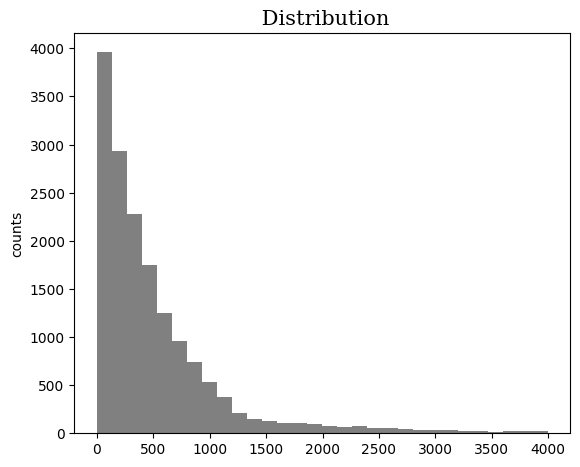

In [14]:
gc_sample.apply_conditions('r3d<4000', inplace=True)
grasp.plots.histogram(gc_sample.r3d.value)

### Density (WOW, bad!)

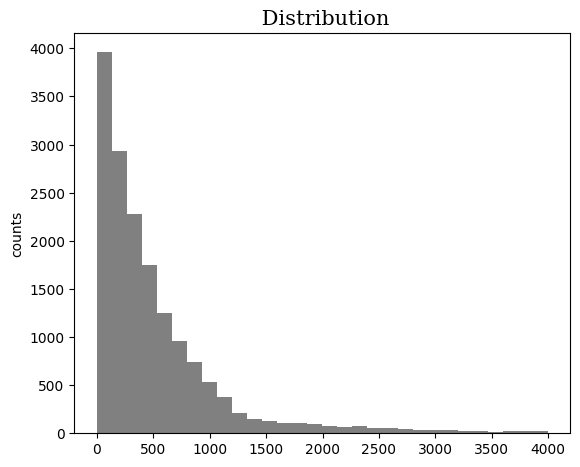

In [15]:
r3dh = grasp.plots.histogram(gc_sample.r3d.value, dont_show=True)

n_bin = len(r3dh['h']['bins'])

V = np.zeros(n_bin)
rr1 = np.zeros(n_bin+1)
rr2 = np.zeros(n_bin+1)

bw = (gc_sample.r3d.value).max()/n_bin

rr1[0] = 0.
rr2[0] = bw

for x in range (0, n_bin):
  V[x] = (4/3)*np.pi*(rr2[x]**3 - rr1[x]**3)
  rr1[x+1] = rr1[x] + bw
  rr2[x+1] = rr2[x] + bw

rho3D = r3dh['h']['counts']/(V*u.pc**3)  

In [16]:
r_c = (1/gc_sample.gc.px[0].value*1000) * np.tan(gc_sample.gc.rc.to(u.rad).value)

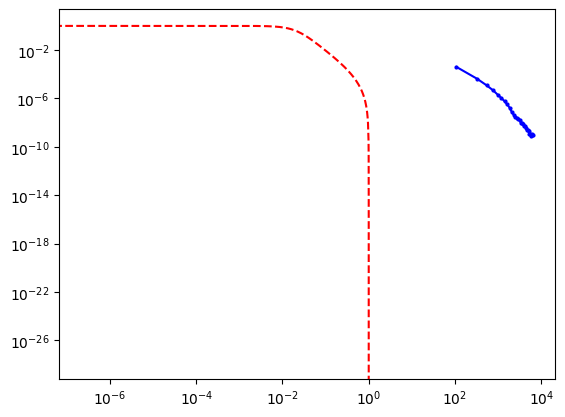

In [17]:
plt.plot(gc_sample.gc.model['xi'], gc_sample.gc.model['rho'], '--', c='red', label='SM King Model')
plt.plot(((rr1[0:n_bin]+rr2[0:n_bin])/2)/r_c, rho3D.value, '-o', markersize=2, c='blue', label='Observed Density')
plt.xscale('log')
plt.yscale('log')

### Setting up the velocities

In [18]:
ff.add_formula('Velocity conversion', r"Eq(v_i,r_c*tan(theta))")
ff.velocity_conversion

Eq(v_i, r_c*tan(theta))

In [19]:
gc_sample['pmra'].unit

Unit("mas / yr")

In [20]:
gc_sample['v_x'] = ((gc_sample.pmra - gc_sample.gc.pmra[0]).to(u.rad/u.s) * ((1/gc_sample.gc.px[0].value)*u.kpc).to(u.km)) / u.rad 
gc_sample['v_y'] = ((gc_sample.pmdec - gc_sample.gc.pmdec[0]).to(u.rad/u.s) * ((1/gc_sample.gc.px[0].value)*u.kpc).to(u.km)) / u.rad

In [21]:
vx_med, vx_med_err = grasp.stats.bootstrap_statistic(gc_sample.v_x.value**2, np.median, n_bootstrap=5000, show_progress=True)
vy_med, vy_med_err = grasp.stats.bootstrap_statistic(gc_sample.v_y.value**2, np.median, n_bootstrap=5000, show_progress=True)

vxm, vxm_err = grasp.stats.bootstrap_statistic(gc_sample.v_x.value**2, np.average, n_bootstrap=5000, show_progress=True)
vym, vym_err = grasp.stats.bootstrap_statistic(gc_sample.v_y.value**2, np.average, n_bootstrap=5000, show_progress=True)


Bootstrap: 100%|██████████| 5000/5000 [00:00<00:00, 47737.95it/s]


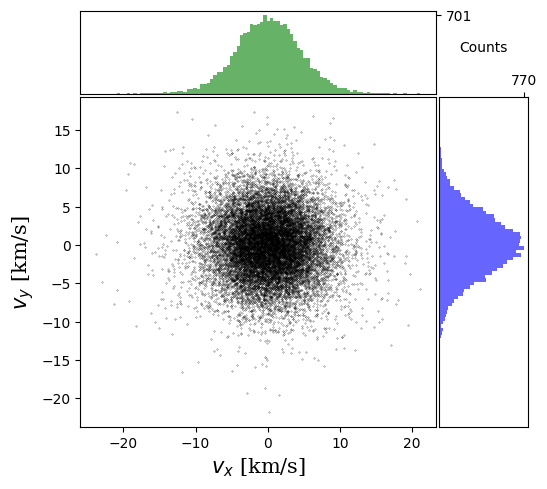

In [22]:
grasp.plots.doubleHistScatter(gc_sample['v_x'].value, gc_sample['v_y'].value, xlabel=r"$v_x$ [km/s]", ylabel=r'$v_y$ [km/s]',size=0.05, alpha=0.85)

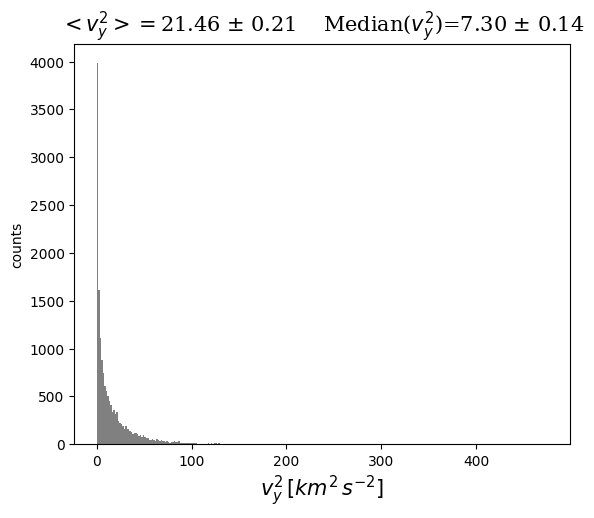

In [23]:
grasp.plots.histogram(
    gc_sample['v_y'].value**2, 
    xlabel=r'$v_y^2 \, [km^2\,s^{-2}]$', title=r'$<v_y^2> = ${:.2f} $\pm$ {:.2f}    Median($v_y^2$)={:.2f} $\pm$ {:.2F}'.format(
        vxm, vym_err,
        vy_med, vy_med_err
        )
    )

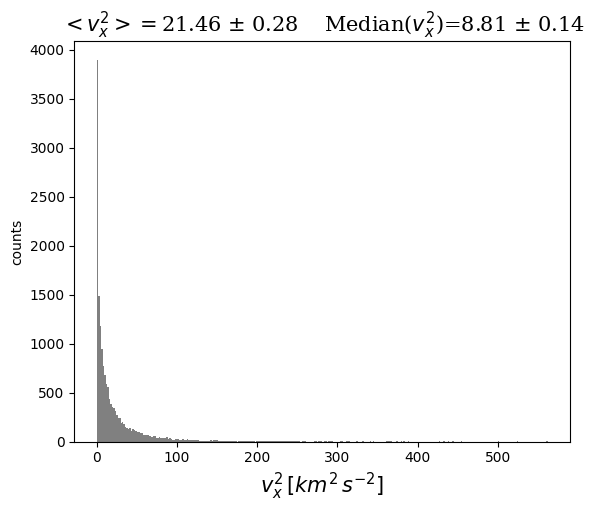

In [24]:
grasp.plots.histogram(
    gc_sample['v_x'].value**2, 
    xlabel=r"$v_x^2 \, [km^2\,s^{-2}]$", title=r'$<v_x^2> = ${:.2f} $\pm$ {:.2f}    Median($v_x^2$)={:.2f} $\pm$ {:.2f}'.format(
        vxm, vxm_err,
        vx_med, vx_med_err
        )
    )

On Isotropy assumption, compute the total (squared) velocity as:

$$ V^2 = \frac{3}{2}(v_x^2 + v_y^2)^2

Bootstrap: 100%|██████████| 5000/5000 [00:00<00:00, 6051.83it/s]


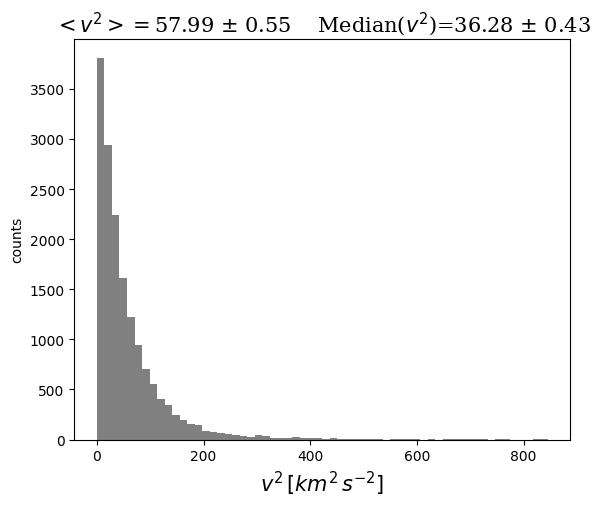

In [25]:
gc_sample['v2'] = 1.5*(gc_sample['v_x']**2 + gc_sample['v_y']**2) 
v2m, v2m_err = grasp.stats.bootstrap_statistic(gc_sample.v2.value, np.average, n_bootstrap=5000, show_progress=True)
v2_med, v2_med_err = grasp.stats.bootstrap_statistic(gc_sample.v2.value, np.median, n_bootstrap=5000, show_progress=True)
v2h = grasp.plots.histogram(
    gc_sample['v2'].value, 
    xlabel=r"$v^2 \, [km^2\,s^{-2}]$", title=r'$<v^2> = ${:.2f} $\pm$ {:.2f}    Median($v^2$)={:.2f} $\pm$ {:.2f}'.format(
        v2m, v2m_err,
        v2_med, v2_med_err
        ),
    out=True
    )

### Shell Partition

In [217]:
# Desired number of instances per subsample
n_per_shell = 250  # for example

# Sort by r3d
sorted_sample = gc_sample.to_pandas().sort_values('r3d')

# Split into equal-length subsamples
shell_samples = [
    sorted_sample.iloc[i:i + n_per_shell]
    for i in range(0, len(sorted_sample), n_per_shell)
]

# Optionally, filter out the last shell if it's too small
shell_samples = [s for s in shell_samples if len(s) == n_per_shell]

In [218]:
v2 = grasp.types.QTable()
R  = grasp.types.QTable()

for i,shell in enumerate(shell_samples):
    
    R[f"s{i}"] = shell['r3d']
    v2[f"s{i}"] = shell['v2']

v2 = grasp.Sample(v2, gc)
R = grasp.Sample(R, gc)

/home/pietrof/git/GRASP/grasp/plots.py:460: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _plt.figure(figsize=fsize)


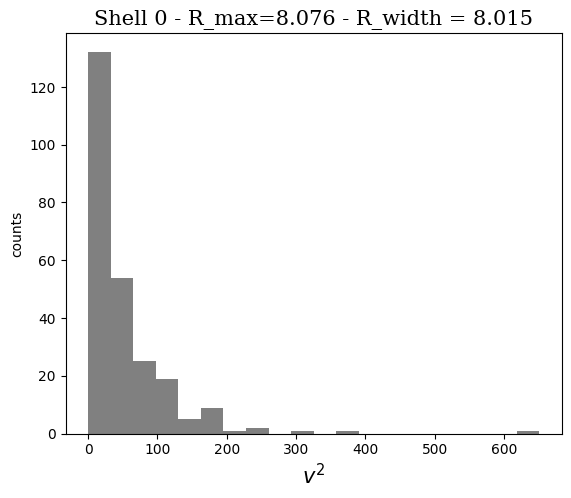

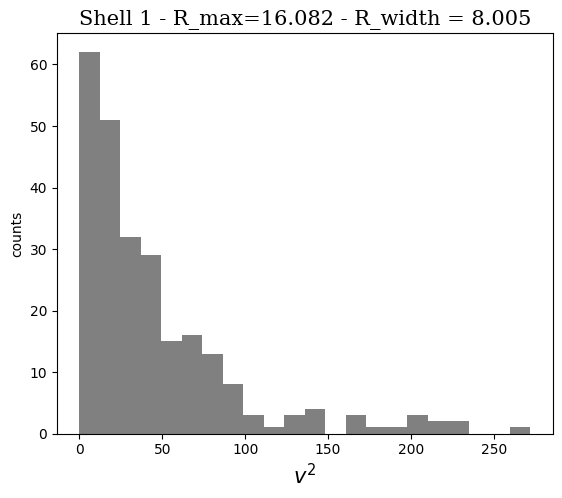

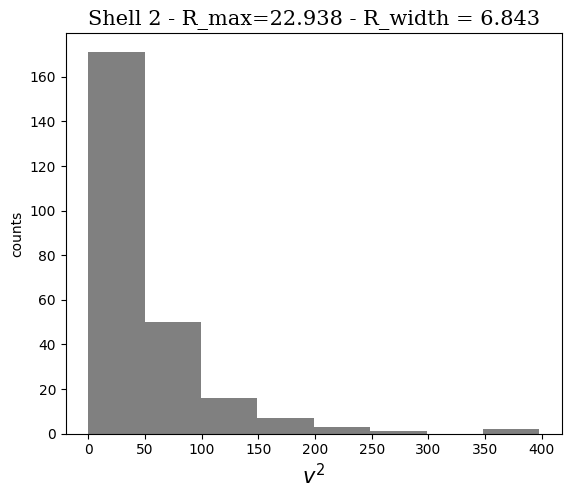

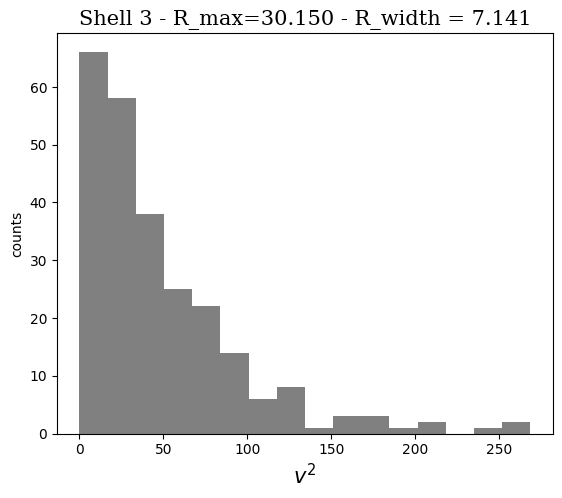

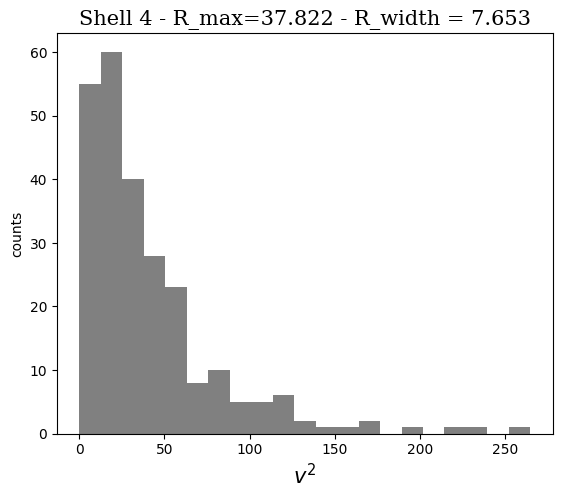

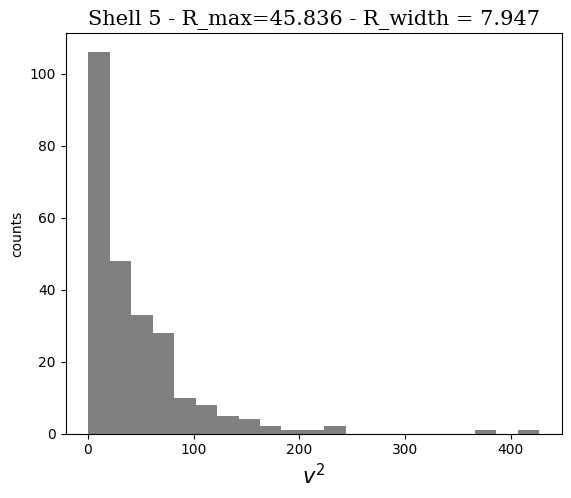

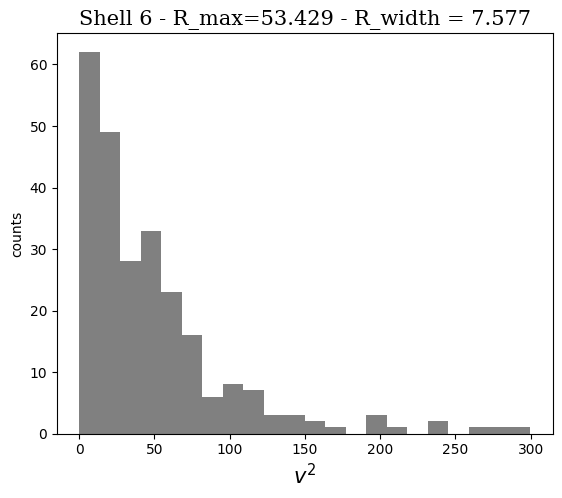

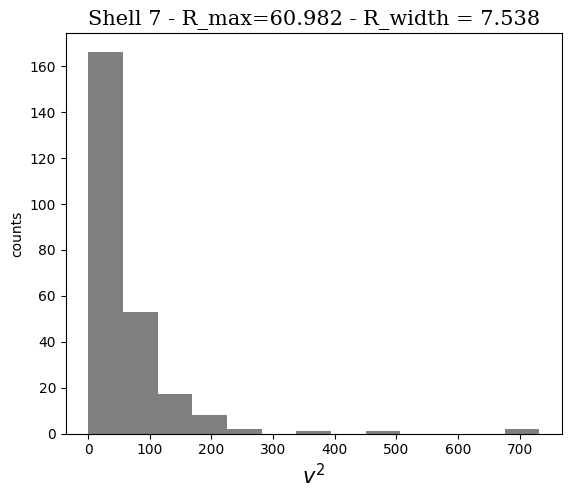

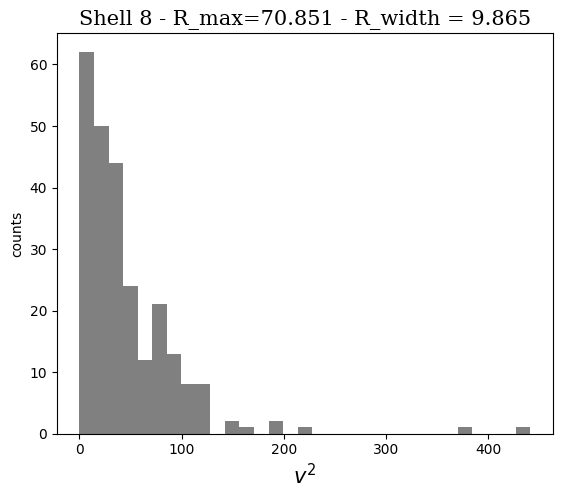

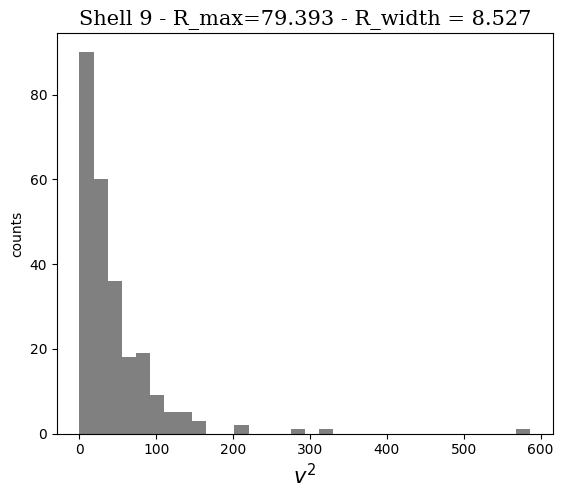

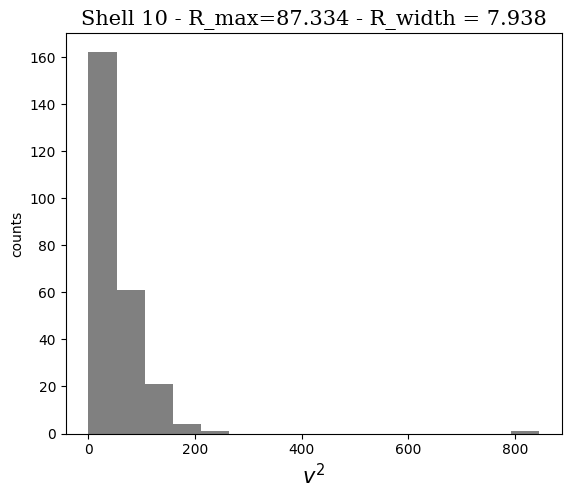

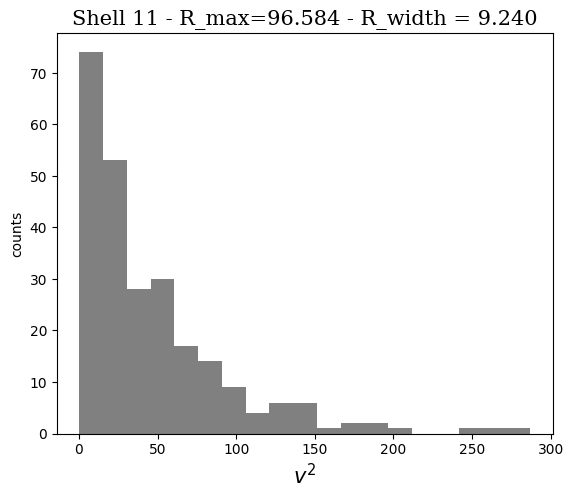

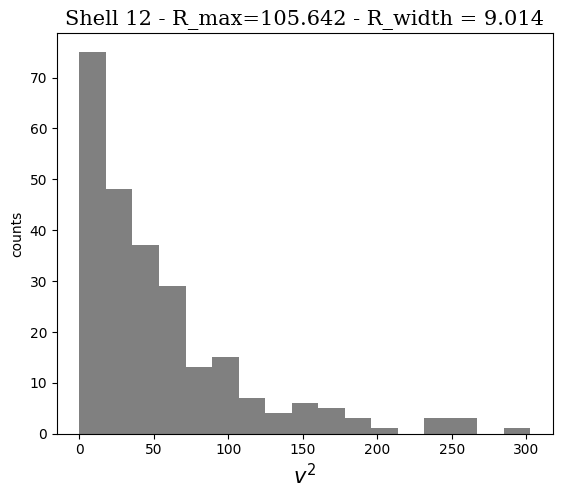

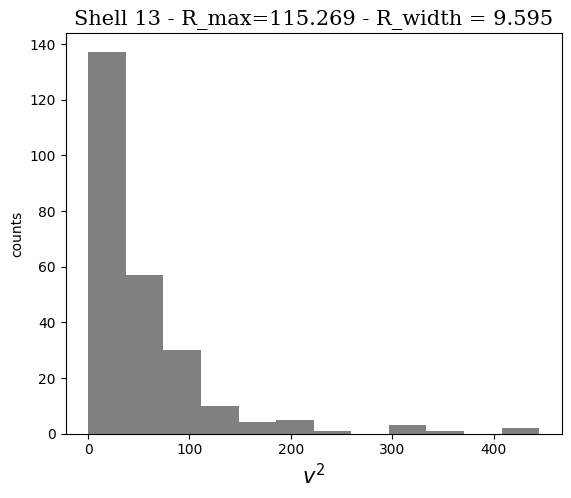

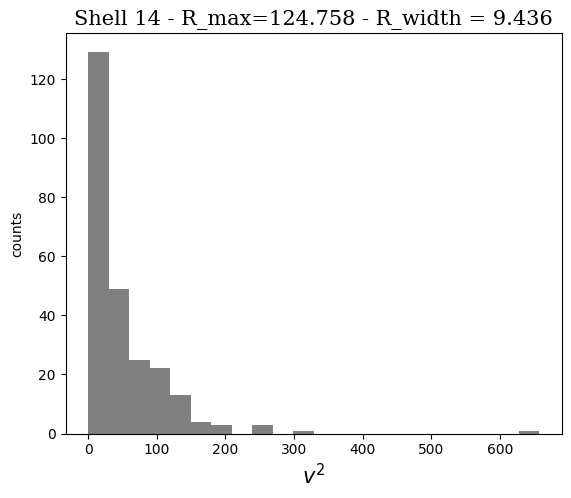

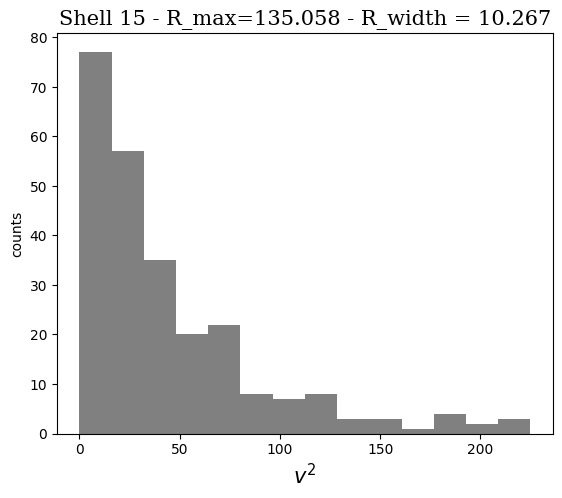

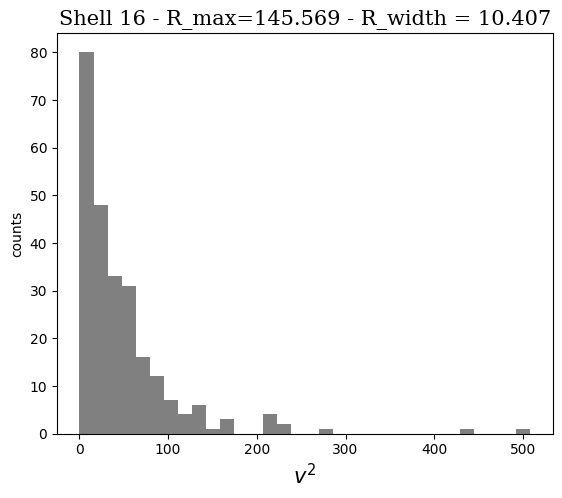

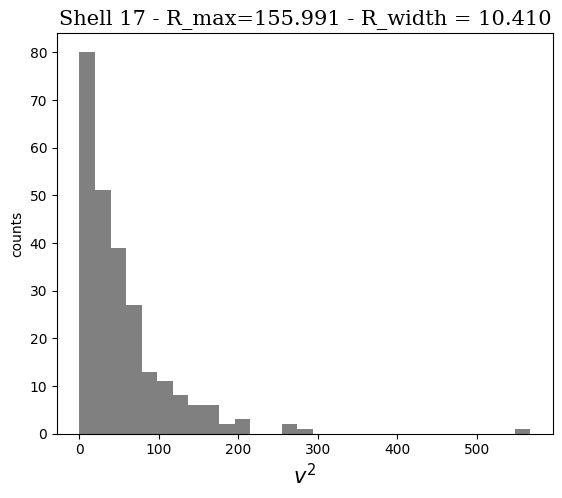

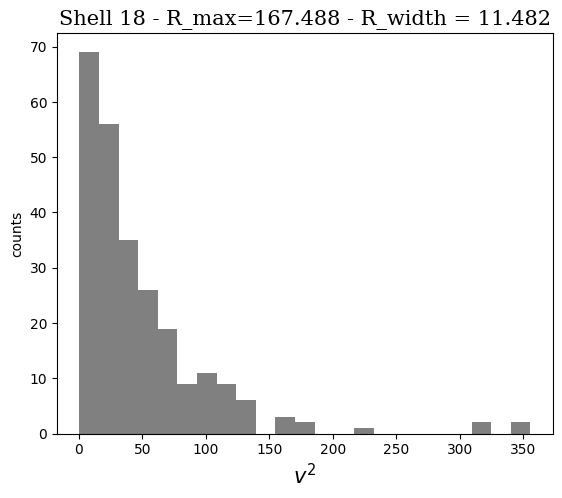

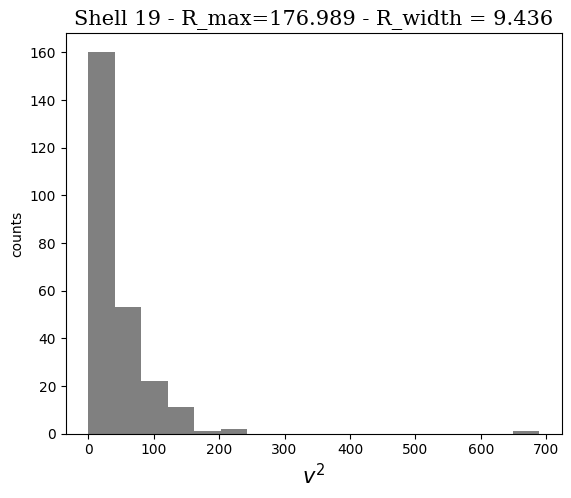

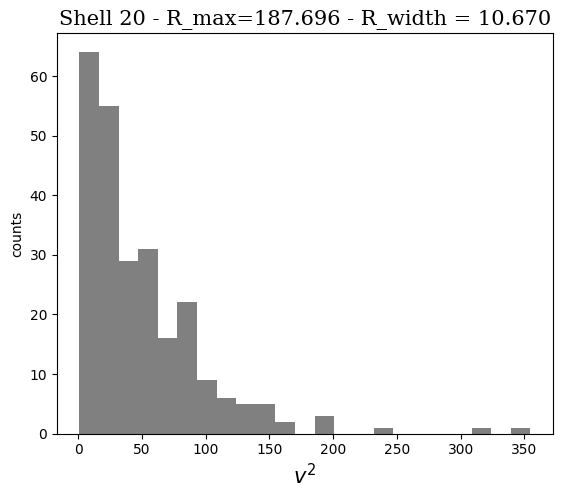

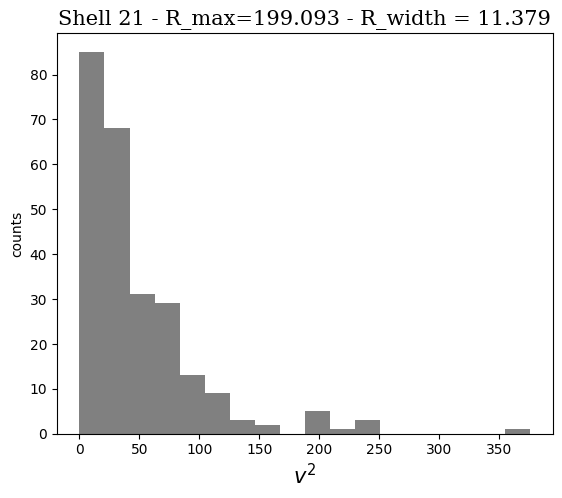

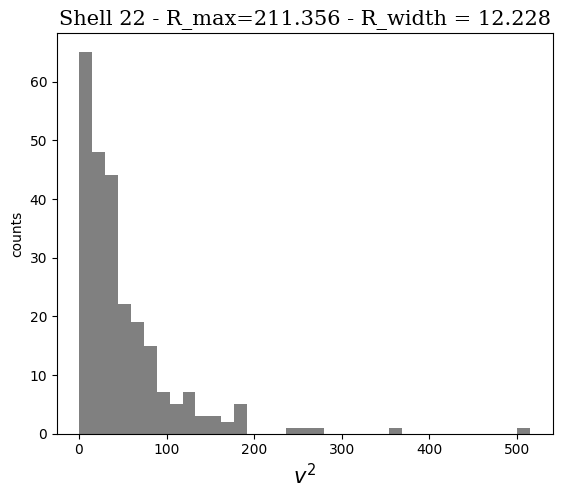

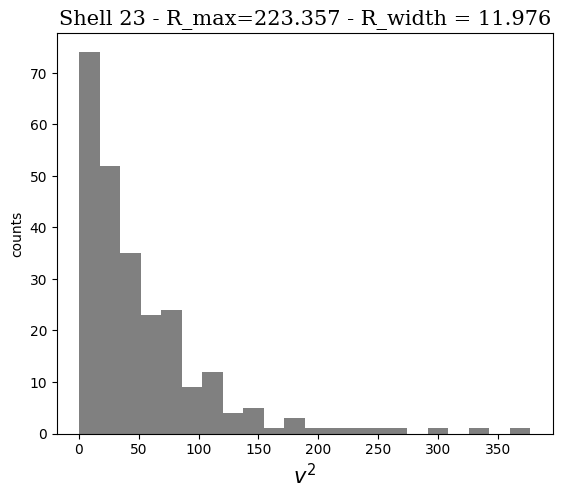

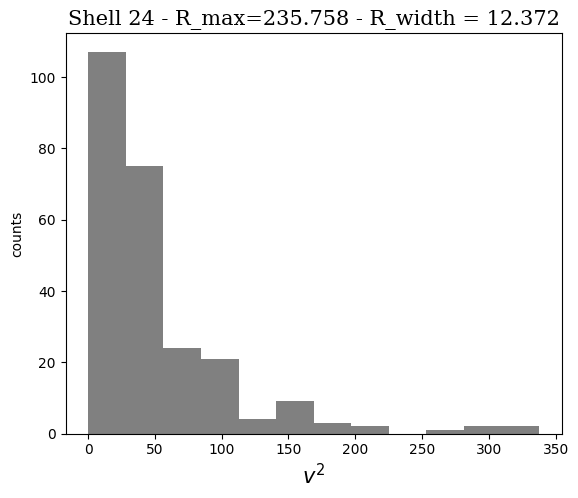

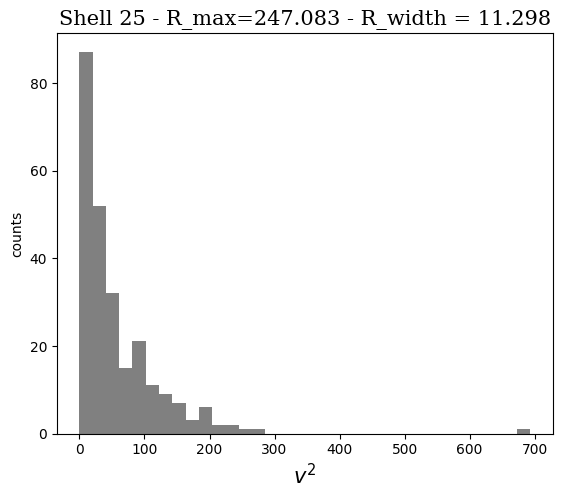

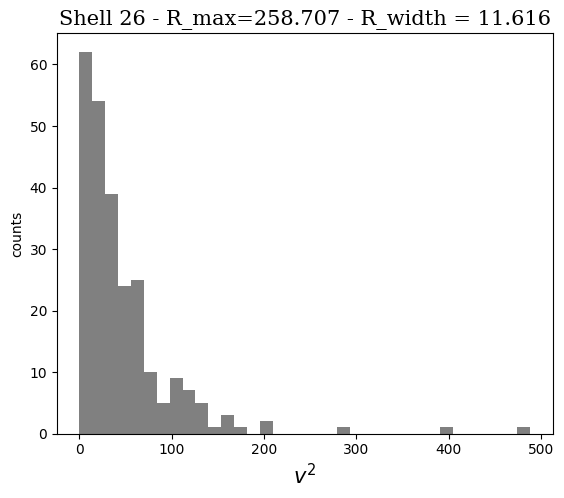

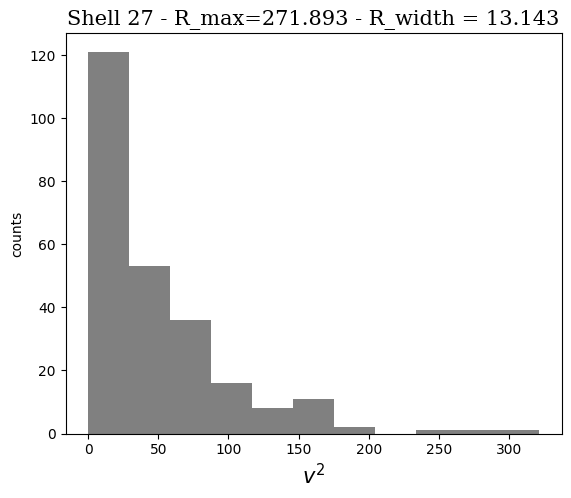

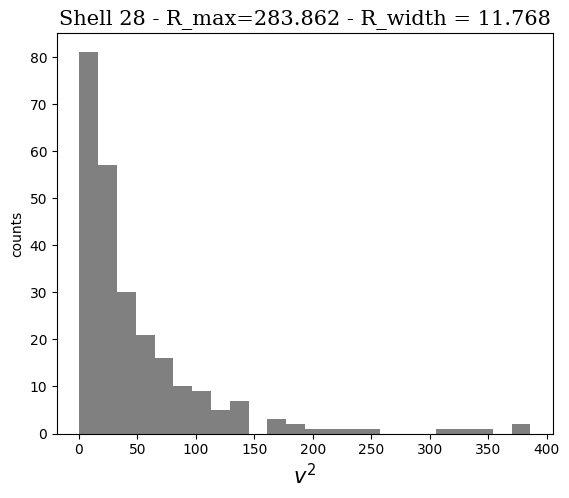

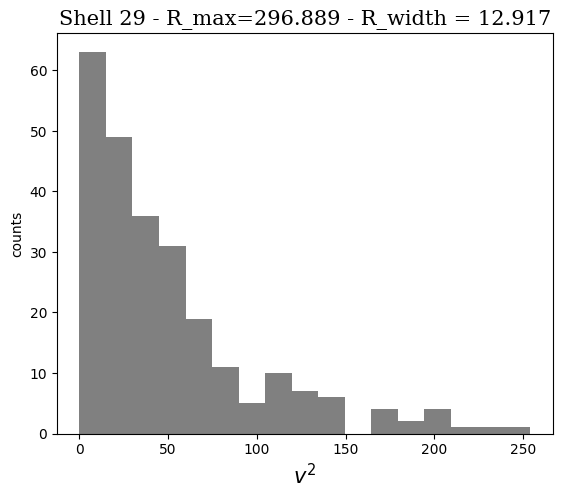

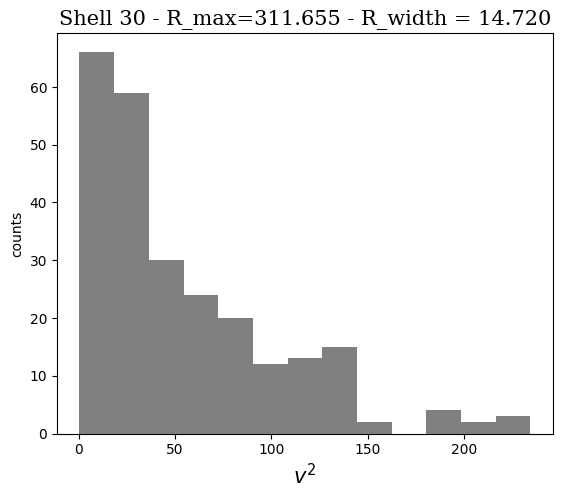

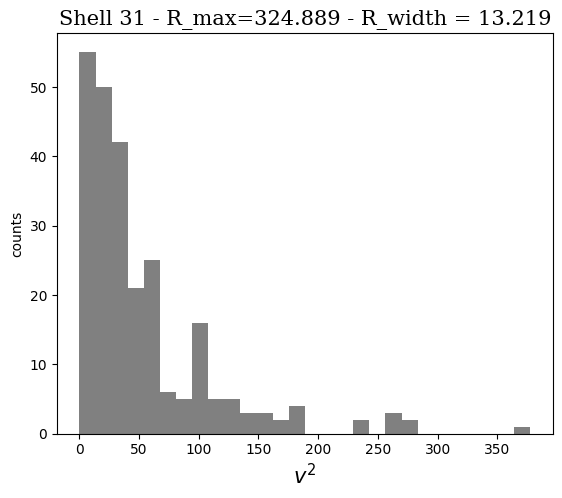

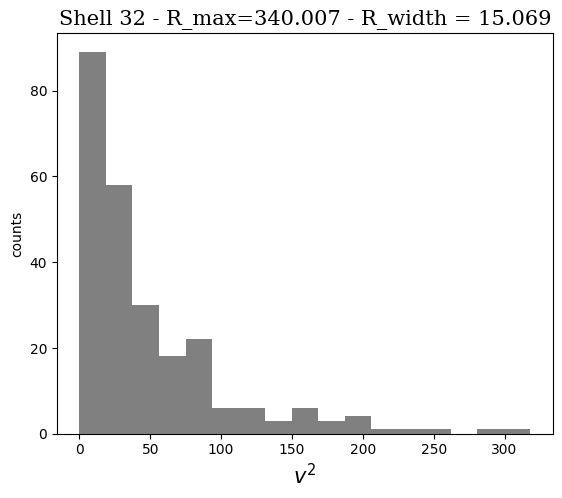

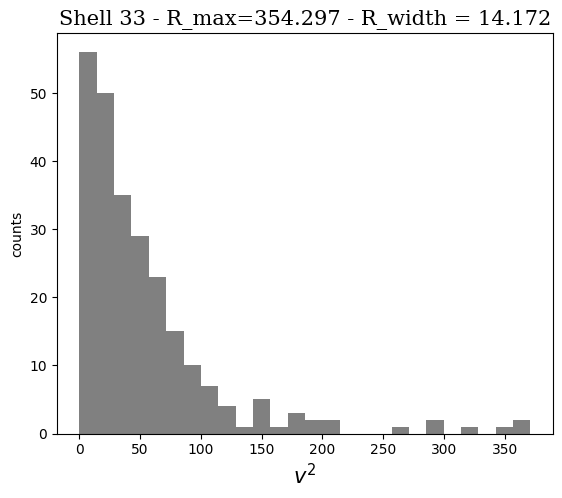

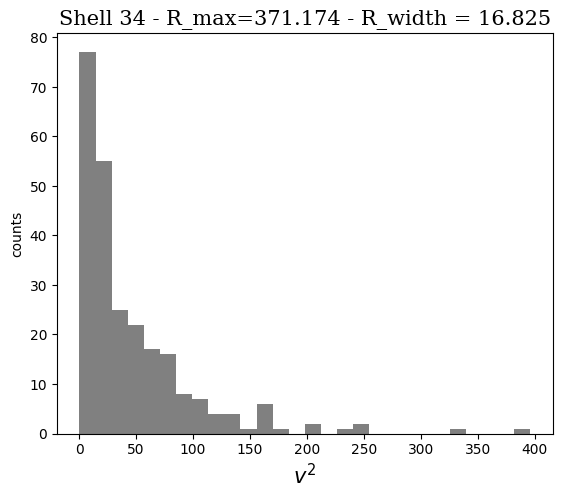

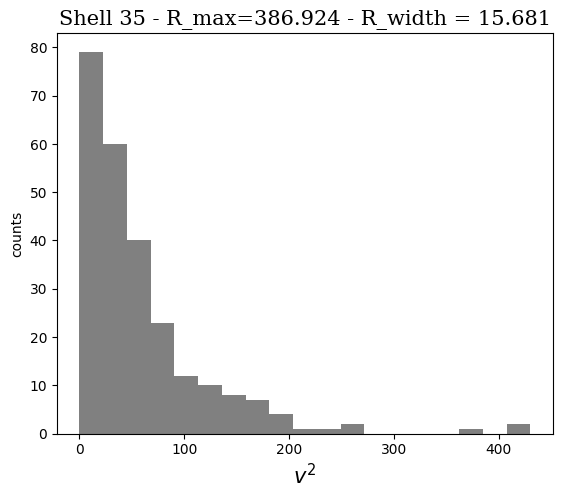

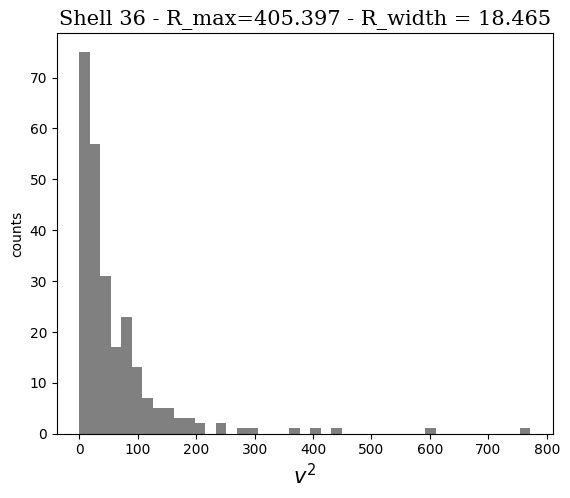

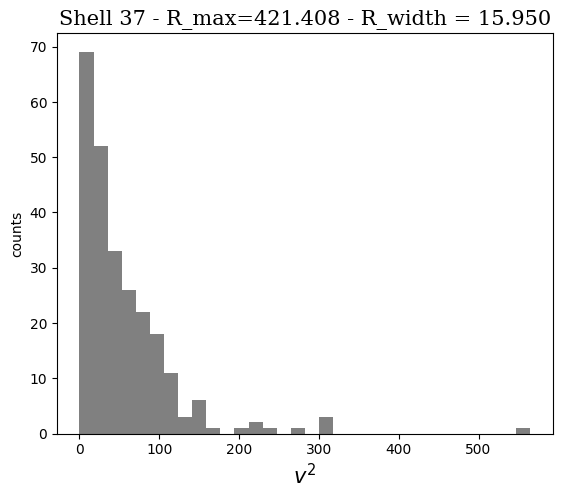

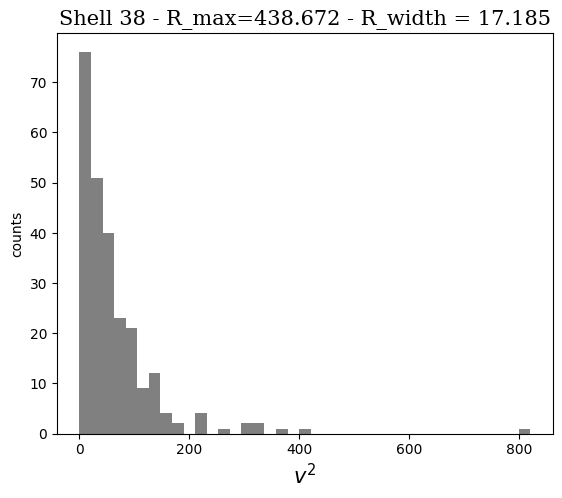

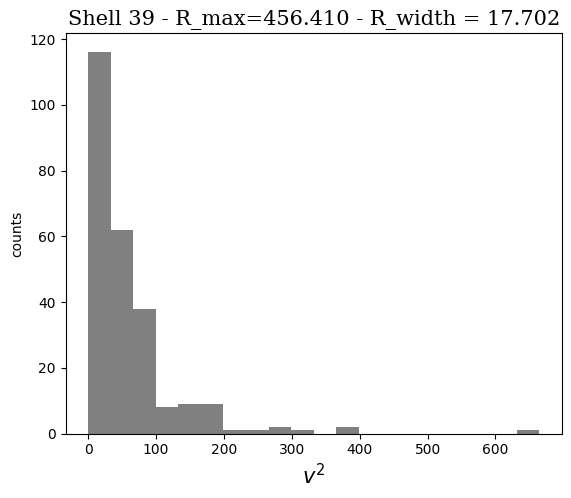

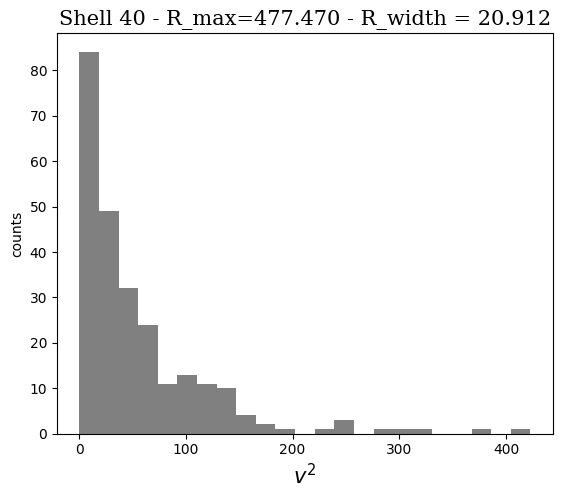

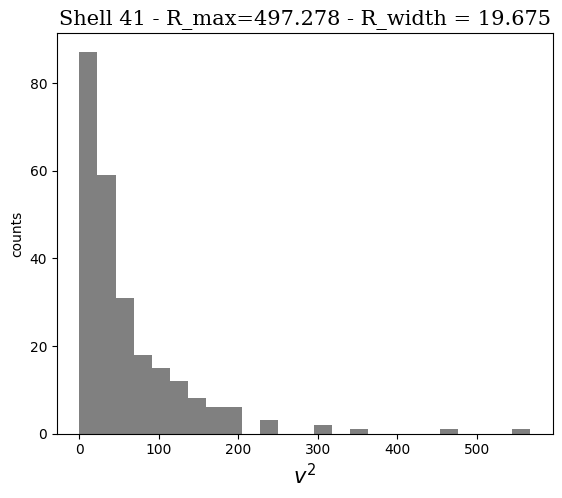

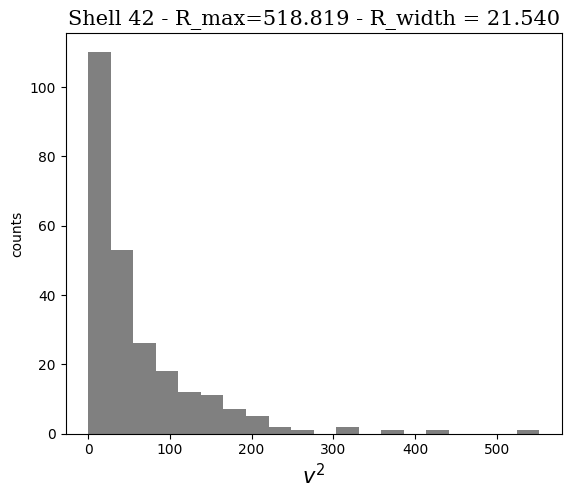

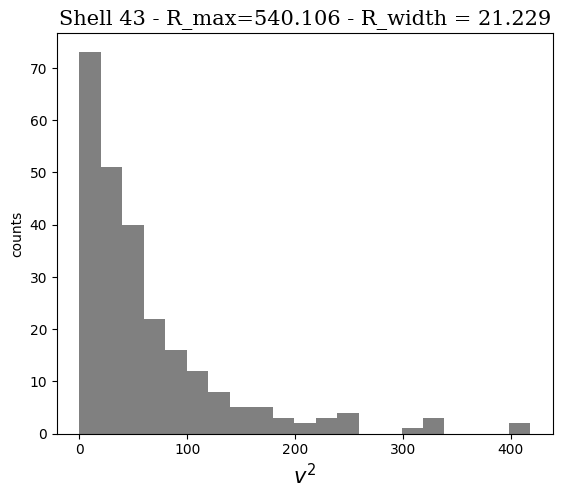

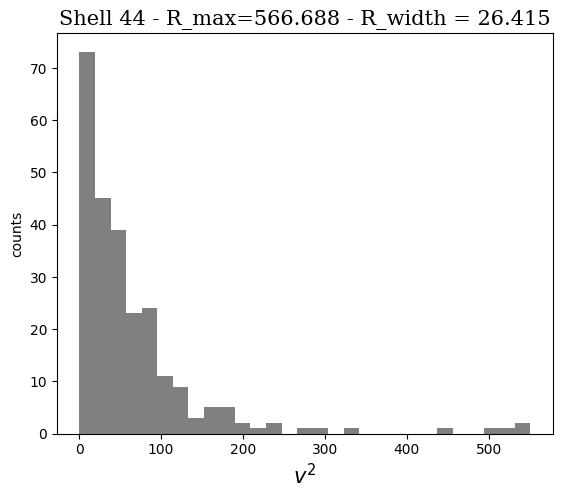

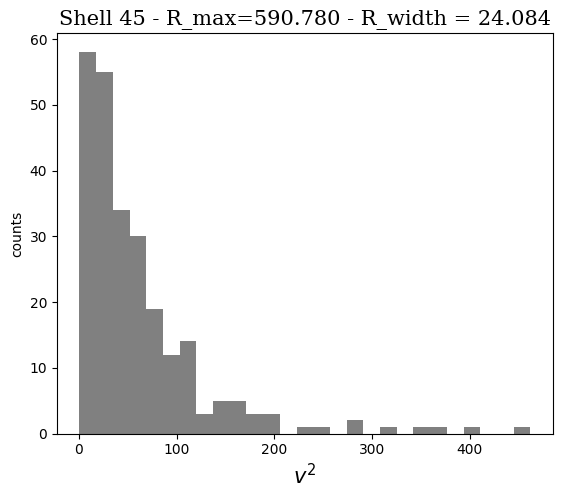

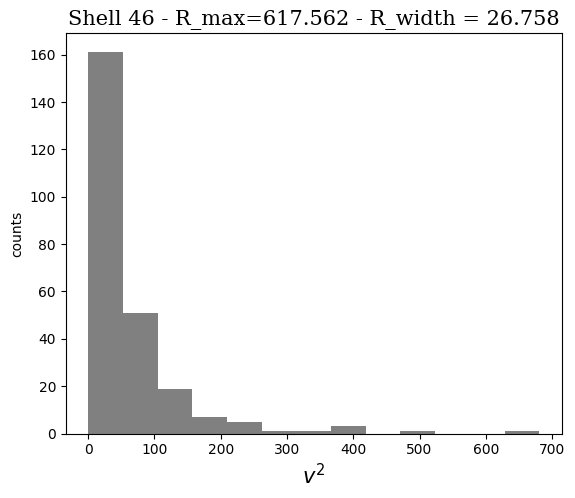

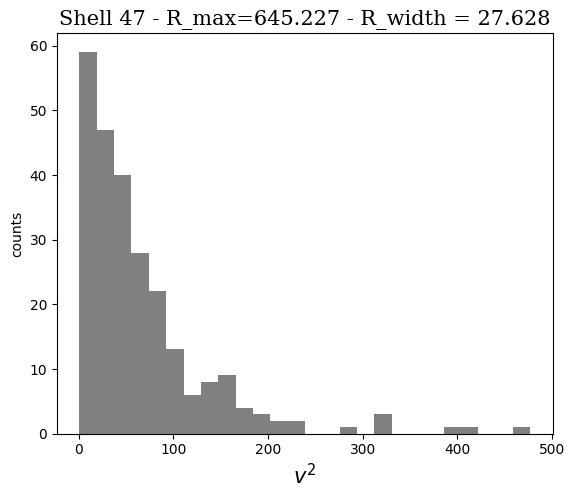

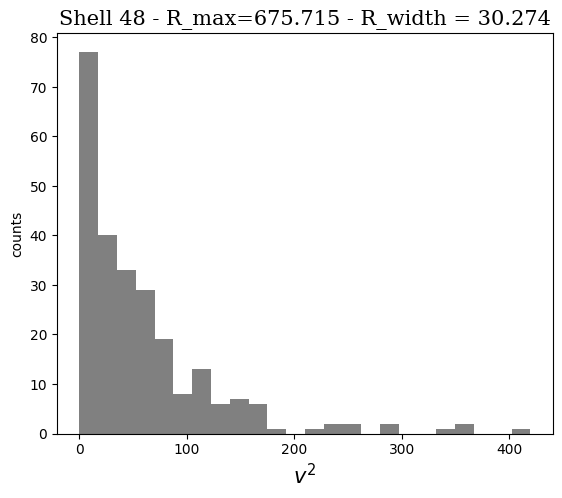

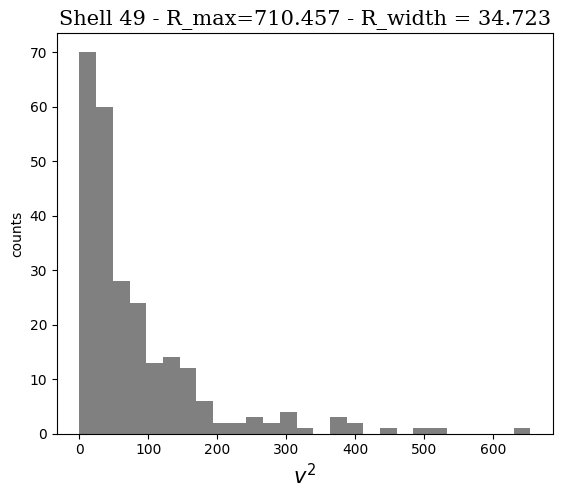

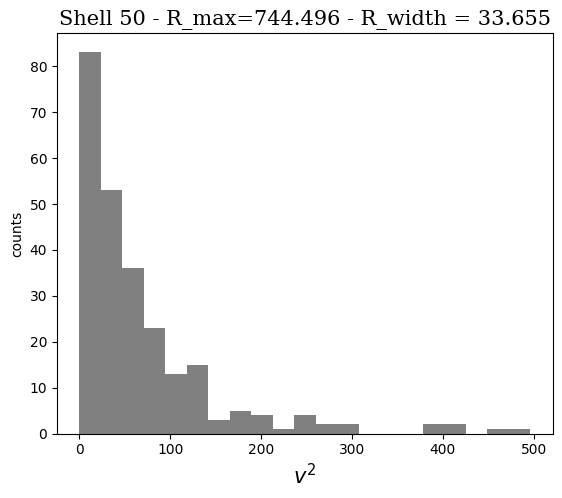

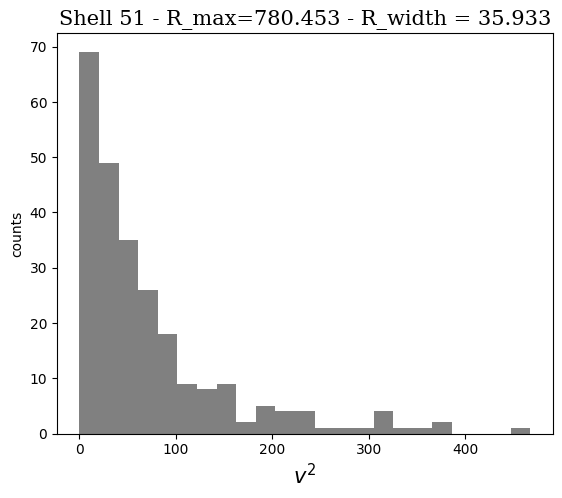

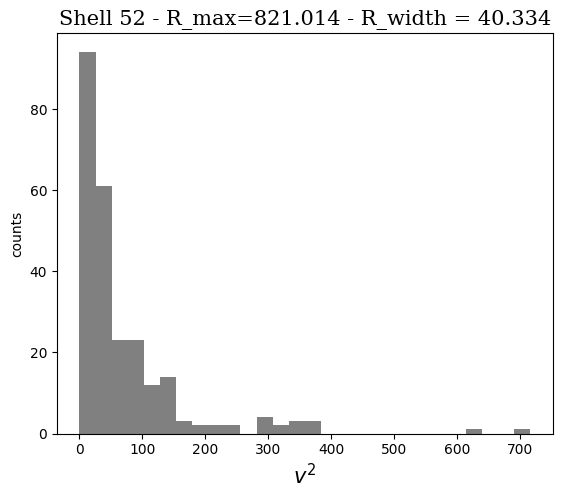

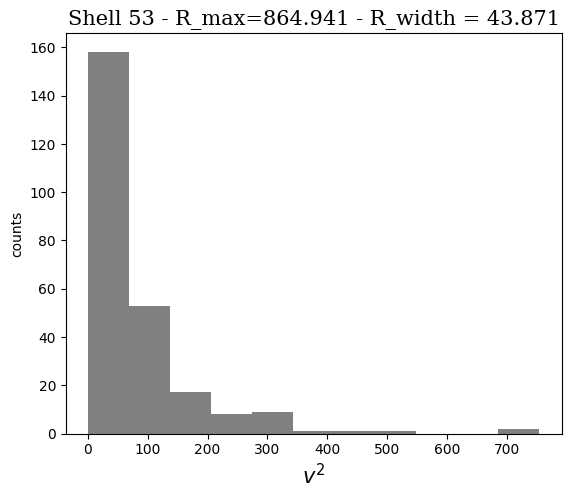

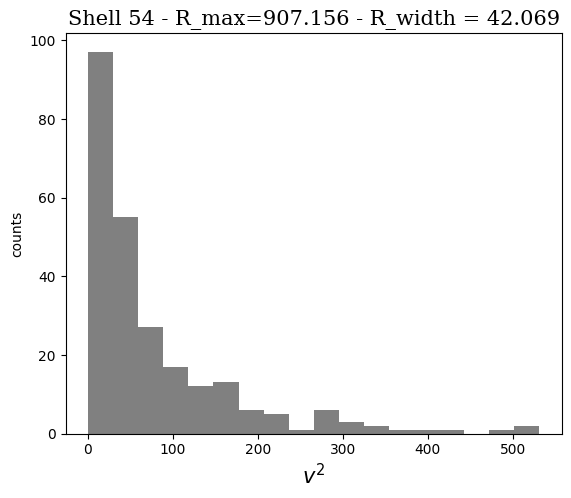

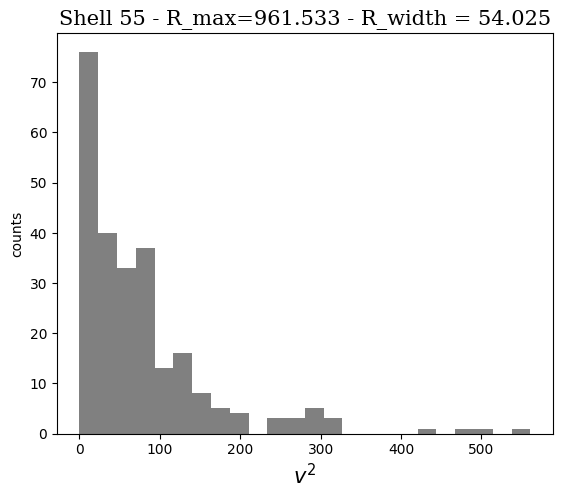

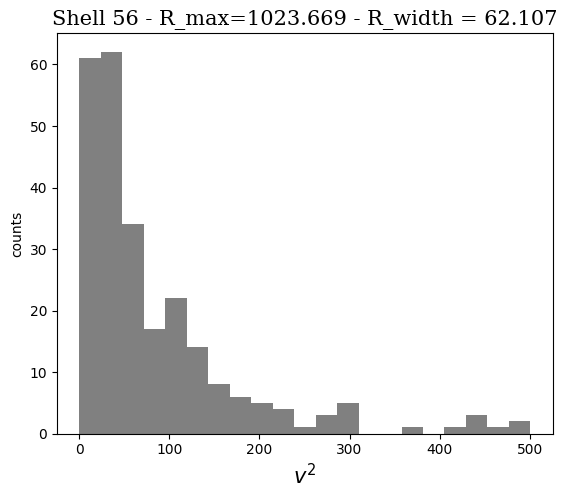

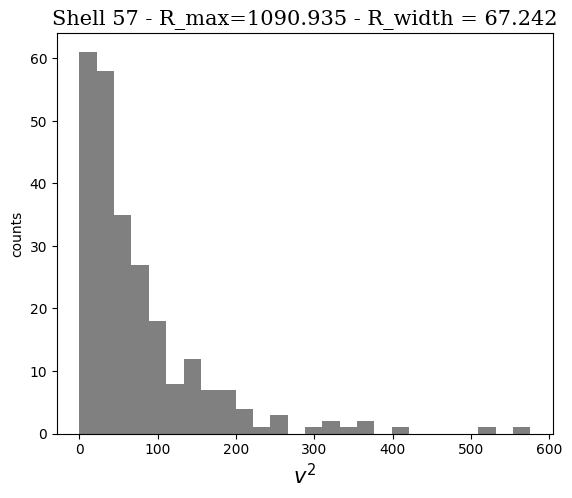

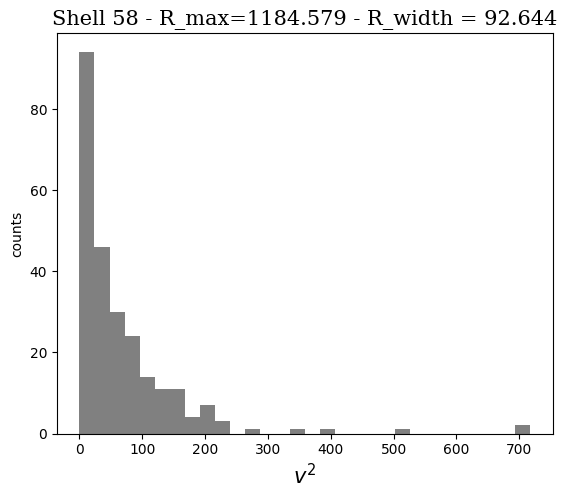

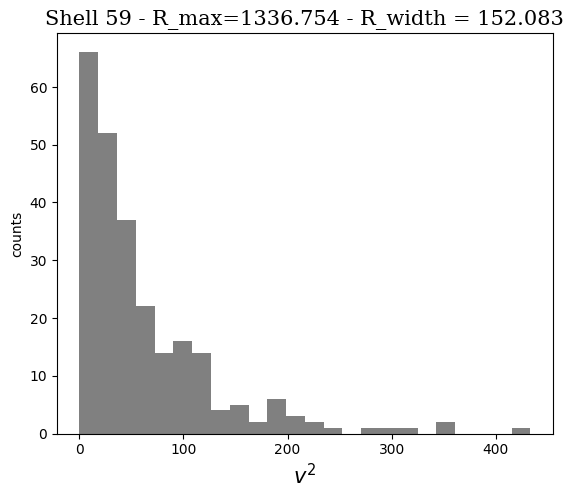

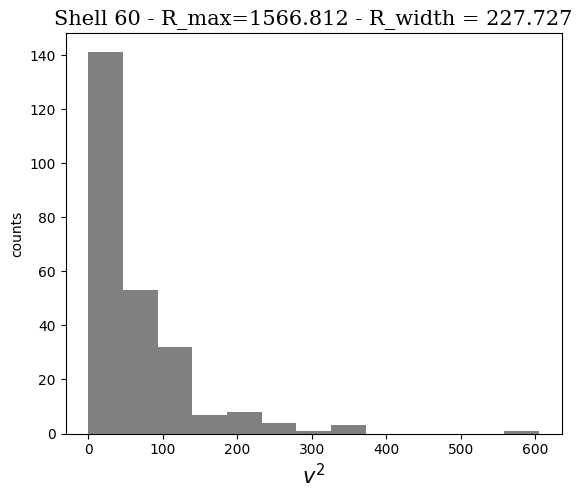

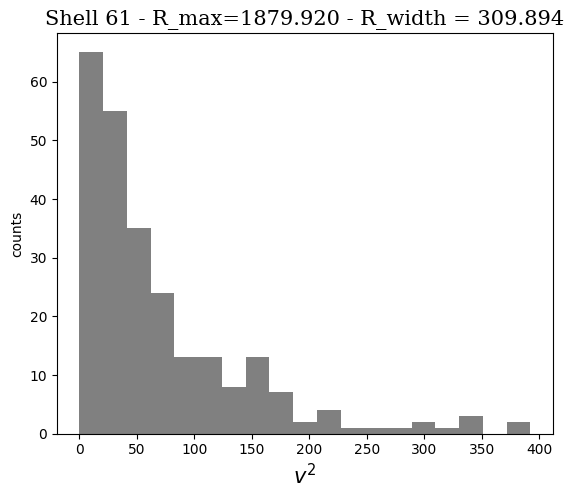

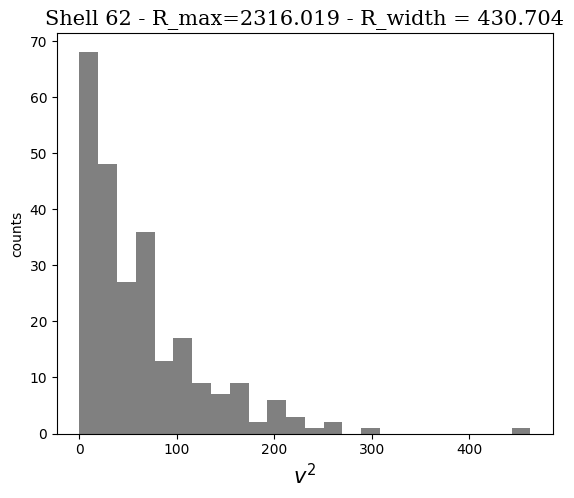

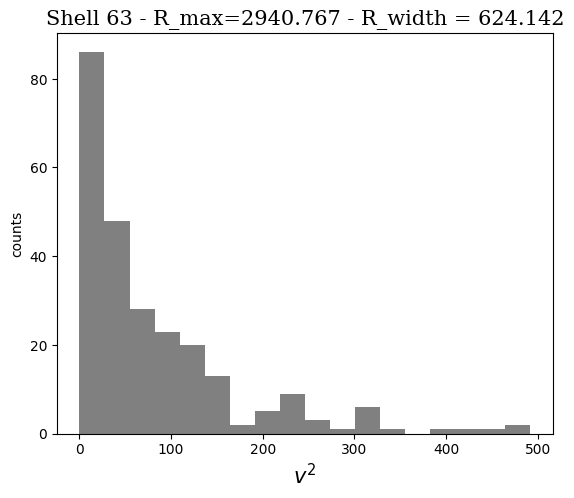

In [219]:
v2h = []
for i in range(len(shell_samples)):
    v2h.append(grasp.plots.histogram(v2[f's{i}'], xlabel='$v^2$', title=f'Shell {i} - R_max={R[f"s{i}"].max():.3f} - R_width = {R[f"s{i}"].max() - R[f"s{i}"].min():.3f}', dont_show=True))

## $B = 16 A \sqrt{2} \pi^2 \beta^2 r_{s}^2 \alpha m^3 \sigma^3 dr dx$

### Constants:

> Normalization constant: $A = 1$

> Single star Mass: $m = 1$

> Incompleteness parameter: $\alpha = 10^{-3}$


In [220]:
A = 1.
alpha = .001
m = 1.

ff.substitute('B constant', 
              {
                  'A': A,
                  'alpha': alpha,
                  'm': m
              }
)

In [221]:
ff.b_constant

Eq(B, 0.016*sqrt(2)*beta**2*dr*dx*pi**2*r_{s}**2*sigma**3)

### $\sigma^2$ : critical velocity 

It is taken to be the maximum quadratic velocity of the shell $v^2\{shell\}^{max}$. <br>
It's the memory of the Maxwellian velocity distribution of the system.

In [222]:
sigmas = []
for i,s in enumerate(shell_samples):
    sigmas.append(np.sqrt(s.v2.max()))

sigmas = np.array(sigmas)

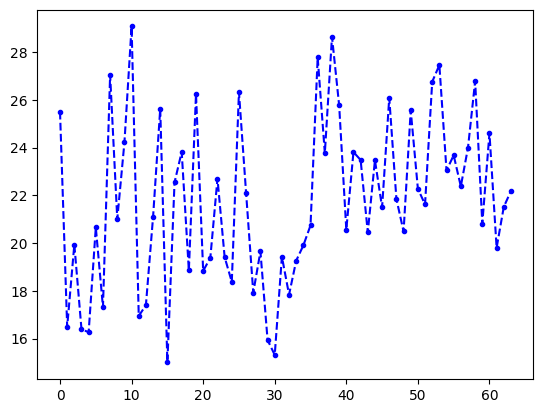

In [223]:
plt.plot(sigmas, '--o', markersize=3, c='blue')

### $\beta$ & $r_s$
 $\beta$ : Estimation from bootstrap statistics on shell<br>
Its the uncertainty parameter on the distance of the shell from the centre of the GC. <br>
This parameter could be estimated by computing the uncertainty of the median <br>
(not the mean, as outliers could heavily affect the result) of the $R_{3D}$ distances of <br>
the stars of the shell from the centre

$r_s$ : Median distance from the centre

In [224]:
betas = []
rss = []

for i, s in enumerate(shell_samples):
    r, b = grasp.stats.bootstrap_statistic(
        s['r3d'],
        np.median,
        n_bootstrap=100,
        show_progress=False
    )
    betas.append(b)
    rss.append(r)

    
betas = np.array(betas)
rss = np.array(rss)

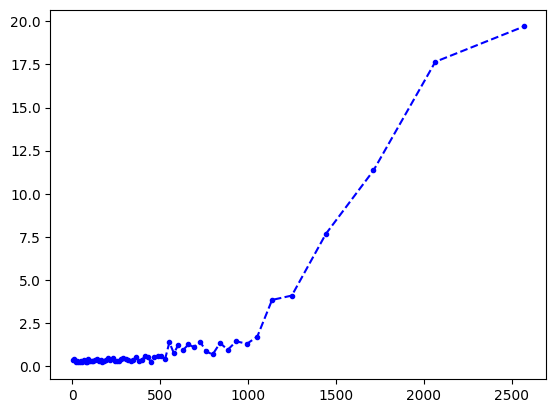

In [225]:
plt.plot(rss, betas, '--o', markersize=3, c='blue')

### $N$ , $x$

In [227]:
Ns = []
x = []

for i, v in enumerate(v2h):
    Ns.append(v['h']['counts'])
    x.append(v['h']['bins']/(2*sigmas[i]**2))


### $dx$ and $dr$

In [228]:
dr = []
dx = []

for i, s in enumerate(shell_samples):
    dr.append(s.r3d.max() - s.r3d.min())
    dx.append(v2h[i]['h']['bins'][1] - v2h[i]['h']['bins'][0])

## $\Sigma = \ln{B} - x - \ln{\frac{\Delta_N}{\sqrt{x}}}$

In [229]:
def Sigma(
    B: float,
    n: int = None,
    fit: grasp.types.Optional[grasp.types.RegressionModels] = None
) -> tuple[grasp.types.ArrayLike, grasp.types.ArrayLike]:
    """Computes analythical sigma"""
    xi = np.linspace(0, 0.5, 1000)
    if fit:
        #xi = np.linspace(0, 0.5, len(fit.x))
        A, l = fit.coeffs
        n = A* np.exp(l * xi)
    elif n is None:
        raise ValueError("Either n or alpha must be provided.")
    return (xi, np.log(B) - np.log(n / xi**0.5) - xi)

In [230]:
import grasp.analyzers
import grasp.analyzers.calculus

poteffs = []
Bs = []

for i in range(len(shell_samples)):
    B = float(grasp.analyzers.calculus._sp.N(ff.b_constant.rhs.subs(
        {
            'r_{s}': rss[i],
            'sigma': sigmas[i],
            'dr': dr[i],
            'dx': dx[i],
            'beta' : betas[i],
            'pi': np.pi
        }
    )))
    Bs.append(B)
    poteffs.append(
        np.log(B) - x[i] - np.log(Ns[i] / x[i]**0.5)
    )


/tmp/ipykernel_9704/2741801785.py:20: RuntimeWarning: divide by zero encountered in log
  np.log(B) - x[i] - np.log(Ns[i] / x[i]**0.5)


In [247]:
def plot_poteff(n_shell: int):
    """Plot the effective potential for a given shell or list of shells."""
    fit = grasp.stats.fit_data_points(Ns[n_shell], x_data=x[n_shell], method='exponential')

    fig, ax = plt.subplots(figsize=(8,6.5))
    ax.plot(x[n_shell], poteffs[n_shell], 'o', markersize=4, c='black')
    xi, S = Sigma(Bs[n_shell], fit=fit)
    ax.plot(xi, S, '-', markersize=3, c='red')
    ax.set_ylabel(r'$\Phi_{eff}$', fontdict=grasp.plots.label_font)
    ax.set_xlabel(r'$x$', fontdict=grasp.plots.label_font)
    ax.set_title(f'Shell {n_shell} at ~{rss[n_shell]:.3f} pc', fontdict=grasp.plots.title_font)
    ax.set_xlim((-0.01, 0.51))

    return fig

folder = grasp.gpaths.CLUSTER_DATA_FOLDER(gc_sample.gc.id) + '/poteff_plots'
for i in range(len(shell_samples)):
    fig = plot_poteff(i)
    fig.savefig(f'{folder}/poteff_shell_{i}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)



/tmp/ipykernel_9704/3036955819.py:14: RuntimeWarning: divide by zero encountered in divide
  return (xi, np.log(B) - np.log(n / xi**0.5) - xi)


/tmp/ipykernel_9704/3036955819.py:14: RuntimeWarning: divide by zero encountered in divide
  return (xi, np.log(B) - np.log(n / xi**0.5) - xi)


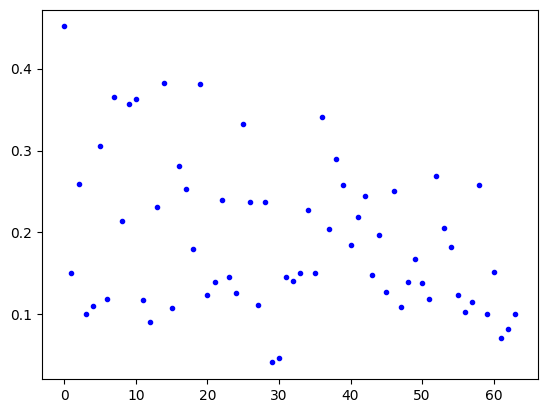

In [262]:
scarti_finali = []
for i in range(len(poteffs)):
    fit = grasp.stats.fit_data_points(Ns[i], x_data=x[i], method='exponential')
    xi, S = Sigma(Bs[i], fit=fit)

    scarti_finali.append(1-poteffs[i][-1]/S[-1])

scarti_finali = np.array(scarti_finali)

plt.plot(scarti_finali, 'o', markersize=3, c='blue')

In [277]:
avg_underestimation = grasp.stats.bootstrap_statistic(scarti_finali, np.mean)

print(f"{avg_underestimation[0]*100 :.2f} +- {avg_underestimation[1]*100:.2f} %")

Bootstrap: 100%|██████████| 1000/1000 [00:00<00:00, 288983.33it/s]

19.24 +- 1.10 %


The average underestimation of the critical velocioty $x=0.5 \rightarrow \sigma^2 = 2\cdot v^2_{max}$ 
is 
> $19,24 \pm  1,10$ %

## $\Sigma = -\ln{1-e^{x-w}}$

In [299]:
dpoteffs = []
Omega = []
s = gc_sample.v2.max()


for i,p in enumerate(poteffs):
    w = np.max(0.5*v2h[i]['h']['bins']/s)
    ssigma = -np.log(1 - np.exp(x[i] - 0.5))
    omega = ssigma - np.array(x[i])
    dpoteffs.append(ssigma)
    Omega.append(omega)



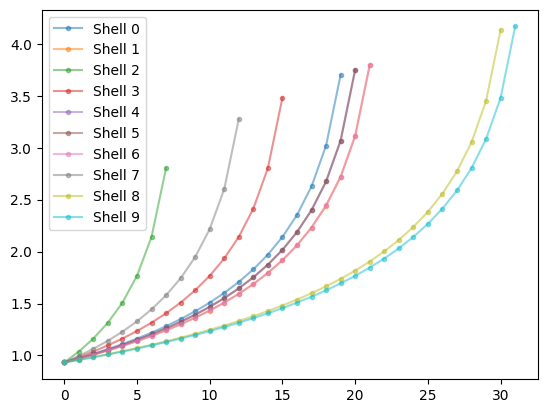

In [309]:
for i in range(10):
    plt.plot(dpoteffs[i], '-o', markersize=3, label=f'Shell {i}', alpha=0.5)

plt.legend(loc='best')